# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl


zsh:1: command not found: pip


/Users/wangxinheng/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [2]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "/Users/wangxinheng/Desktop/cse 151B/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 32,
        "num_workers": 0,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 128,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
        "scheduler_patience": 3, 
        "early_stopping_patience": 10,

    },
    "trainer": {
        "max_epochs": 150,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [3]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**.

We encourage you to build and experiment with your own models and ideas.


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(identity)
        return self.relu(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return self.final(self.dropout(x))


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [5]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [6]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [7]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, training_config):
        super().__init__()
        self.model = model
        self.training_config = training_config
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.training_config['lr']) # Use self.training_config
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            'min', # mode: reduce LR when the monitored quantity (val/loss) stops decreasing
            patience=self.training_config['scheduler_patience'], # Use self.training_config
            factor=0.2,   # factor by which the learning rate will be reduced. new_lr = lr * factor
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss", # Monitor the validation loss logged as "val/loss"
            }
        }
    
    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [8]:
datamodule = ClimateDataModule(**config["data"])
model = SimpleCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)
lightning_module = ClimateEmulationModule(model, training_config=config["training"]) # MODIFIED INSTANTIATION

from pytorch_lightning.callbacks import EarlyStopping # Ensure this import is at the top of the cell

 # Add EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val/loss',  # Monitor the validation loss (make sure this key is logged in validation_step)
    patience=config["training"]["early_stopping_patience"], # From your main config
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
     **config["trainer"], # Spreads keys like max_epochs, accelerator etc.
    callbacks=[early_stopping_callback]
    )

trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


TypeError: You passed a `pytorch_lightning` object (EarlyStopping) to a `lightning.pytorch` Trainer. Please switch to a single import style.

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [41]:
trainer.test(lightning_module, datamodule=datamodule)

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


/Users/wangxinheng/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=289.8692, Time-Mean RMSE=289.8333, Time-Stddev MAE=3.5453
[TEST] pr: RMSE=3.5253, Time-Mean RMSE=3.4040, Time-Stddev MAE=0.7440
✅ Submission saved to: submissions/kaggle_submission_20250516_204902.csv
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/pr/rmse           3.525305986404419
 test/pr/time_mean_rmse      3.403963804244995
  test/pr/time_std_mae      0.7440354228019714
      test/tas/rmse          289.8691711425781
 test/tas/time_mean_rmse    289.83331298828125
  test/tas/time_std_mae     3.5453360080718994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/tas/rmse': 289.8691711425781,
  'test/tas/time_mean_rmse': 289.83331298828125,
  'test/tas/time_std_mae': 3.5453360080718994,
  'test/pr/rmse': 3.525305986404419,
  'test/pr/time_mean_rmse': 3.403963804244995,
  'test/pr/time_std_mae': 0.7440354228019714}]

### Plotting Utils


In [42]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


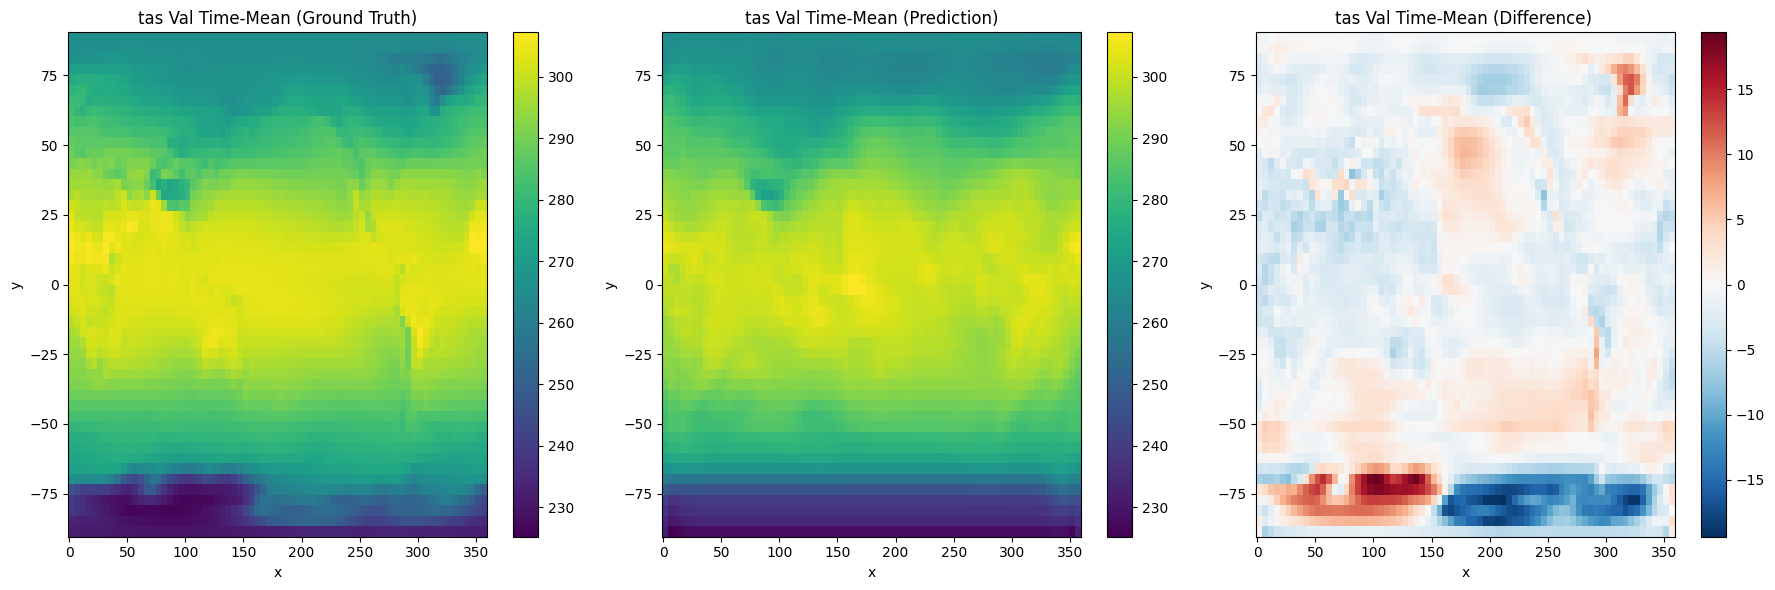

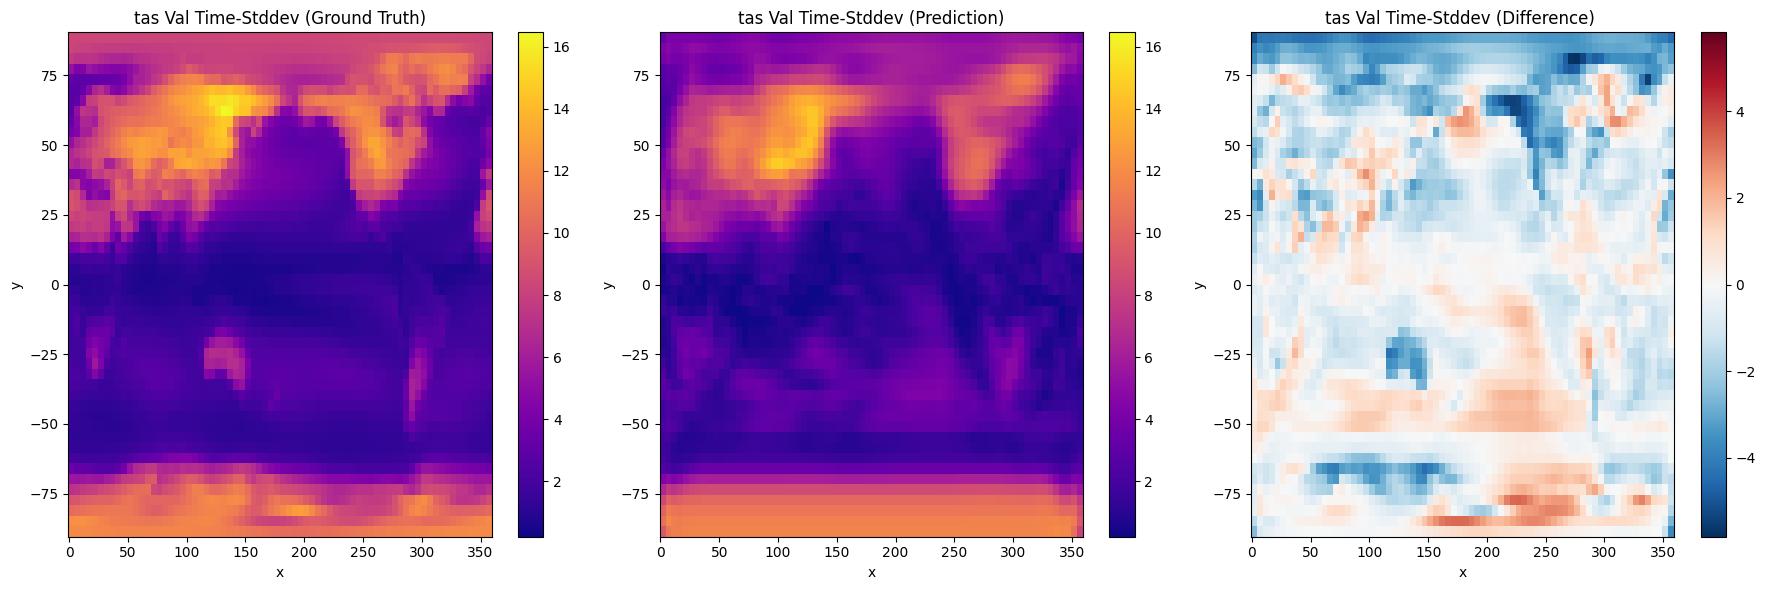

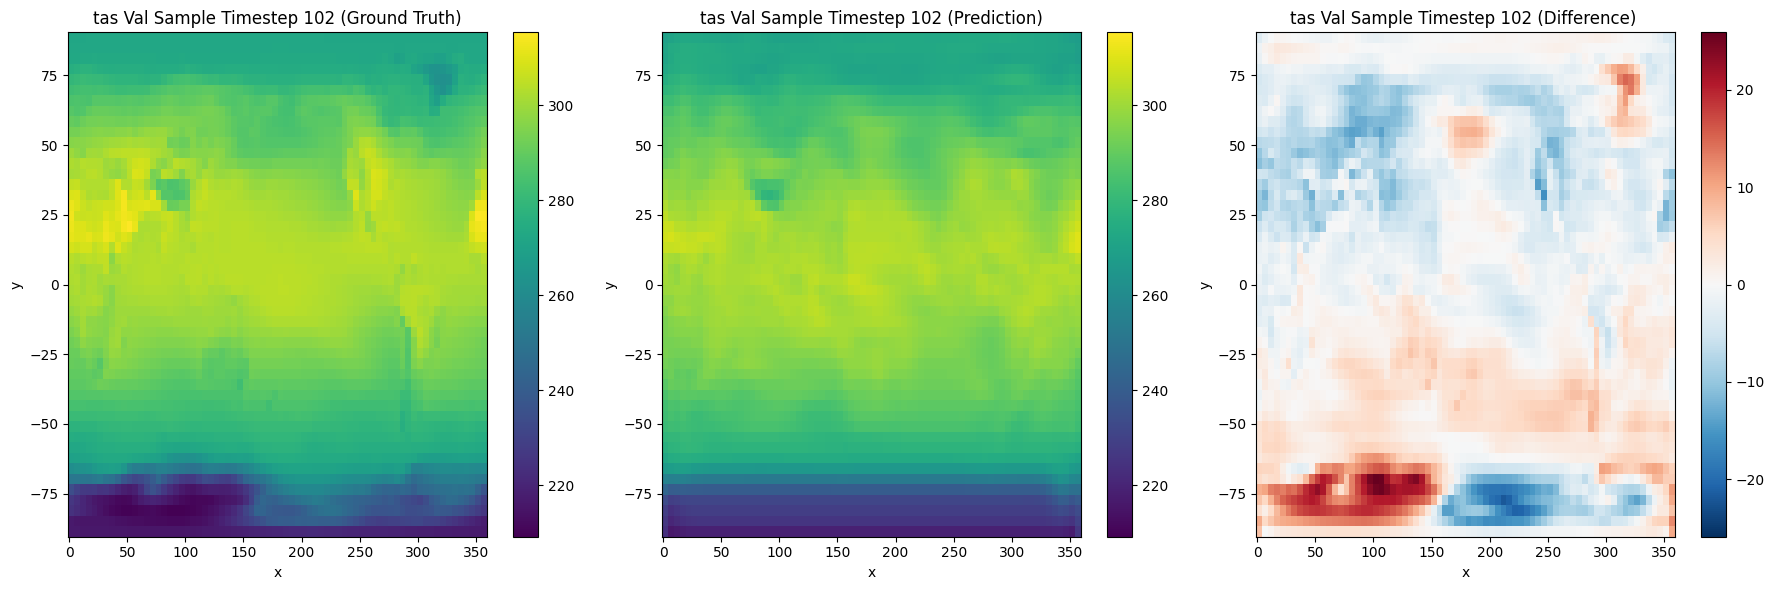

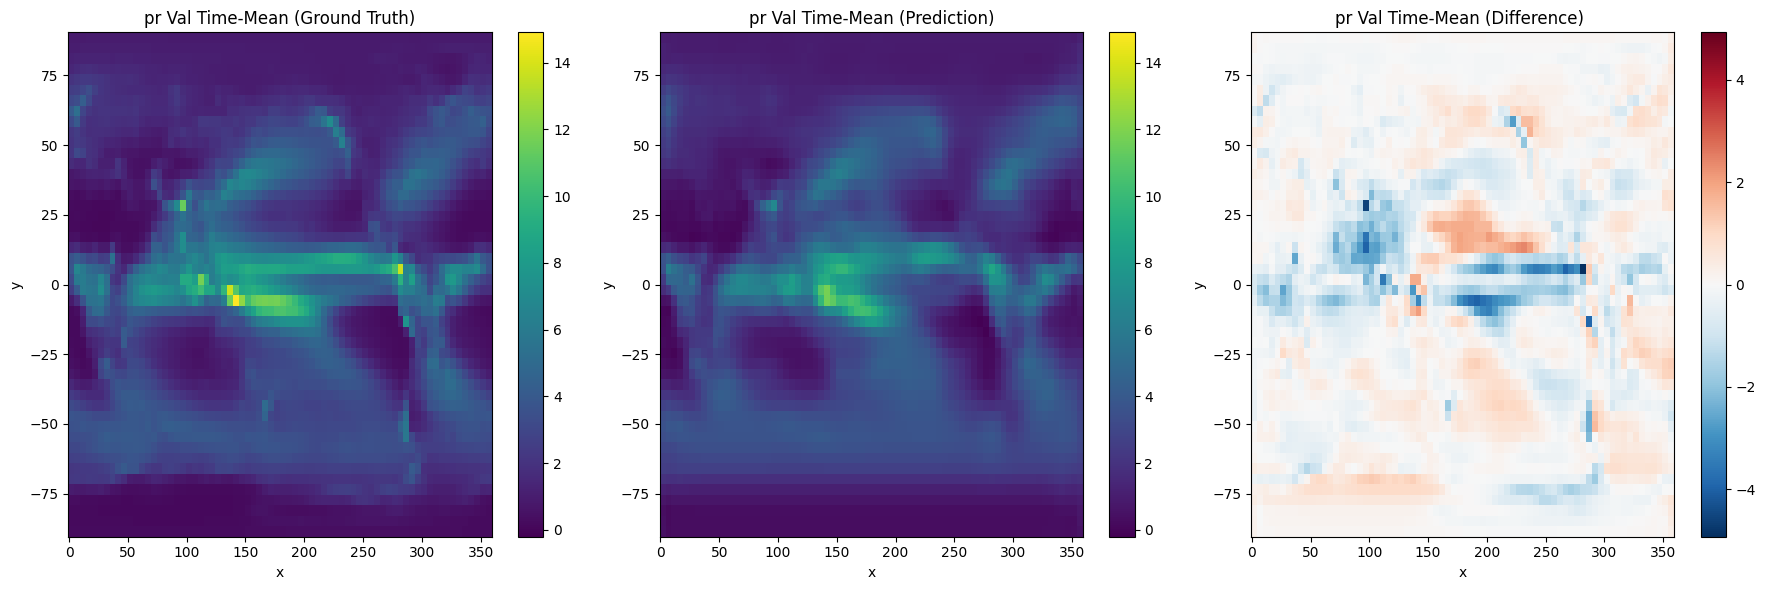

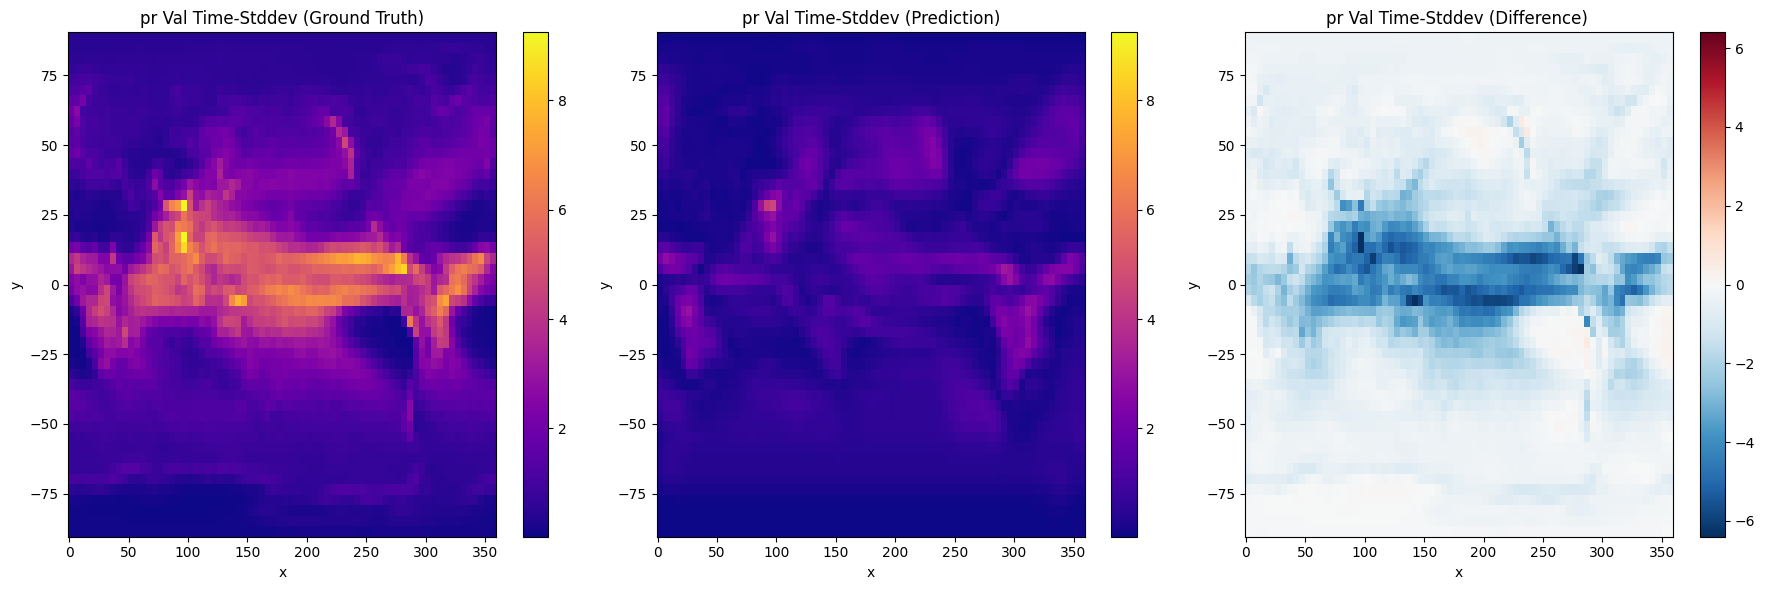

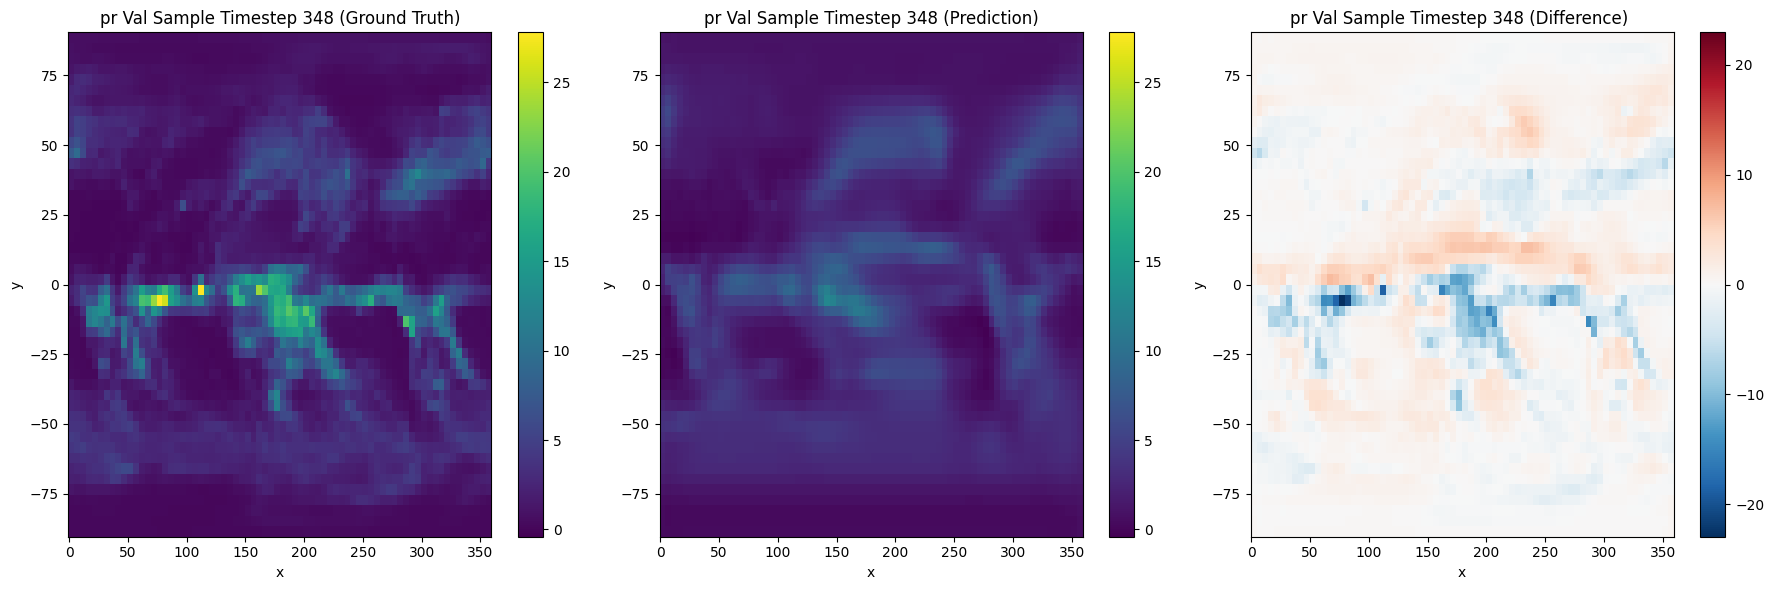

In [43]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`.
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


In [44]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os

# --- Configuration for Visualization ---
# Ensure datamodule and config are defined from previous cells

zarr_path = os.path.expanduser(config["data"]["path"])
ds_raw = xr.open_zarr(zarr_path, consolidated=False)

# Training SSPs and variables from config
train_ssps = config["data"]["train_ssps"]
input_variables = config["data"]["input_vars"]

# Attempt to get lat/lon from the datamodule (if setup was run)
try:
    lat = datamodule.lat
    lon = datamodule.lon
except AttributeError:
    print("Warning: lat/lon not found on datamodule. Attempting to read from a sample variable in ds_raw.")
    try:
        # Try to infer from a known spatial variable, e.g., 'rsdt' or the last input_var
        sample_var_name = 'rsdt' if 'rsdt' in input_variables else input_variables[-1]
        sample_spatial_var = ds_raw[sample_var_name].isel(ssp=0, time=0)
        if 'member_id' in sample_spatial_var.dims: # Select target member if present
            sample_spatial_var = sample_spatial_var.isel(member_id=config["data"].get("target_member_id", 0))

        if "latitude" in sample_spatial_var.coords:
            lat = sample_spatial_var.latitude.values
            lon = sample_spatial_var.longitude.values
        elif "y" in sample_spatial_var.coords: # Check for renamed coordinates
             lat = sample_spatial_var.y.values
             lon = sample_spatial_var.x.values
        else:
            print("Warning: Could not automatically determine lat/lon coordinates from ds_raw.")
            lat, lon = None, None
    except Exception as e:
        print(f"Error getting lat/lon coordinates from ds_raw: {e}")
        lat, lon = None, None

# Identify non-spatial (global time series) vs. spatial input variables
non_spatial_inputs = []
spatial_inputs = []
for var_name in input_variables:
    try:
        sample_var_data = ds_raw[var_name].isel(ssp=0, time=0)
        if 'member_id' in sample_var_data.dims: # Select target member
            sample_var_data = sample_var_data.isel(member_id=config["data"].get("target_member_id", 0))
        
        # Check if dimensions other than 'time' exist (common spatial dim names)
        spatial_dims_present = any(d in sample_var_data.dims for d in ['latitude', 'longitude', 'y', 'x', 'lat', 'lon'])
        
        if not spatial_dims_present and 'time' in sample_var_data.dims: # Only time dimension
            non_spatial_inputs.append(var_name)
        elif spatial_dims_present: # Has spatial dimensions
            spatial_inputs.append(var_name)
        else: # If neither (e.g. scalar, or only ssp dim), treat as non-spatial for now or flag
            print(f"Warning: Variable {var_name} has unusual/non-spatial dimensions {sample_var_data.dims}, treating as non-spatial for plotting.")
            non_spatial_inputs.append(var_name)

    except Exception as e:
        print(f"Could not determine type for variable {var_name}, assuming spatial by default. Error: {e}")
        # Default to spatial if check fails, or handle more gracefully
        if var_name not in non_spatial_inputs: # Avoid double-adding if already classed as non-spatial
            spatial_inputs.append(var_name)


print(f"Identified non-spatial inputs: {non_spatial_inputs}")
print(f"Identified spatial inputs: {spatial_inputs}")

# Target member ID for consistency (used by ClimateDataModule)
target_member_id = config["data"].get("target_member_id", 0)

Identified non-spatial inputs: ['CO2', 'CH4']
Identified spatial inputs: ['SO2', 'BC', 'rsdt']



--- Plotting Non-Spatial Input Variables (Time Series) ---


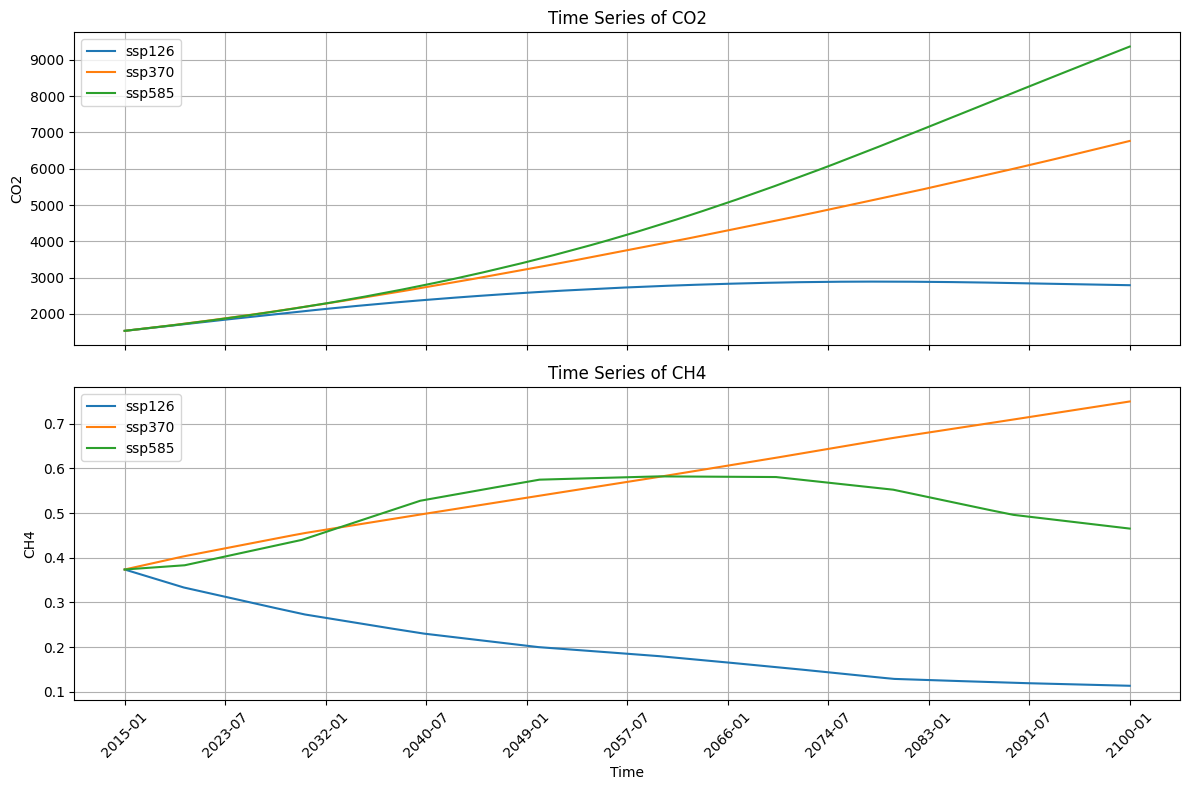

In [45]:
# Plot time series for non-spatial input variables
if non_spatial_inputs:
    print("\n--- Plotting Non-Spatial Input Variables (Time Series) ---")
    num_non_spatial = len(non_spatial_inputs)
    fig, axs = plt.subplots(num_non_spatial, 1, figsize=(12, 4 * num_non_spatial), sharex=True)
    if num_non_spatial == 1: # Ensure axs is always a list
        axs = [axs]

    for i, var_name in enumerate(non_spatial_inputs):
        ax = axs[i]
        for ssp in train_ssps:
            try:
                var_data = ds_raw[var_name].sel(ssp=ssp)
                # If member_id is a dimension for these non-spatial vars, select it
                if 'member_id' in var_data.dims:
                    var_data = var_data.sel(member_id=target_member_id)
                
                # Ensure we have a time coordinate for plotting
                if 'time' in var_data.coords:
                    # Try to format time if it's datetime-like, otherwise use index
                    if hasattr(var_data.time.dt, 'strftime'):
                         time_coords = var_data.time.dt.strftime('%Y-%m').values
                         ax.plot(time_coords, var_data.data, label=f'{ssp}')
                         # Improve x-axis tick visibility if many time points
                         if len(time_coords) > 50:
                             step = len(time_coords) // 10 # Show ~10 ticks
                             ax.set_xticks(time_coords[::step])
                             ax.tick_params(axis='x', rotation=45)
                    else: # If not datetime-like, plot against index
                        ax.plot(np.arange(len(var_data.time)), var_data.data, label=f'{ssp}')

                else: # If no time coord at all, plot raw data against index
                    ax.plot(var_data.data, label=f'{ssp} (index as time)')
                    print(f"Warning: No 'time' coordinate for {var_name} under {ssp}. Plotting against index.")

            except Exception as e:
                print(f"Could not plot {var_name} for {ssp}: {e}")
        ax.set_title(f'Time Series of {var_name}')
        ax.set_ylabel(var_name) # Units might be helpful here if known
        ax.legend()
        ax.grid(True)

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()
else:
    print("No non-spatial input variables identified to plot time series.")



--- Plotting Spatial Input Variables (Time-Averaged Maps) ---


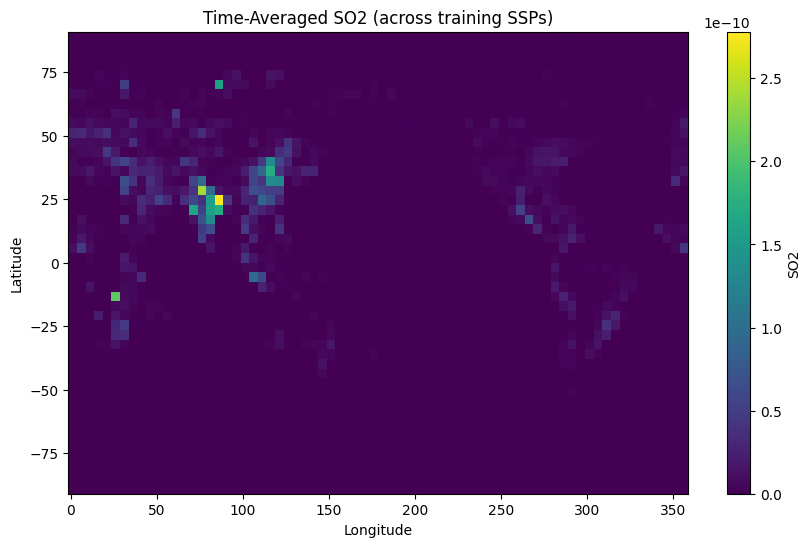

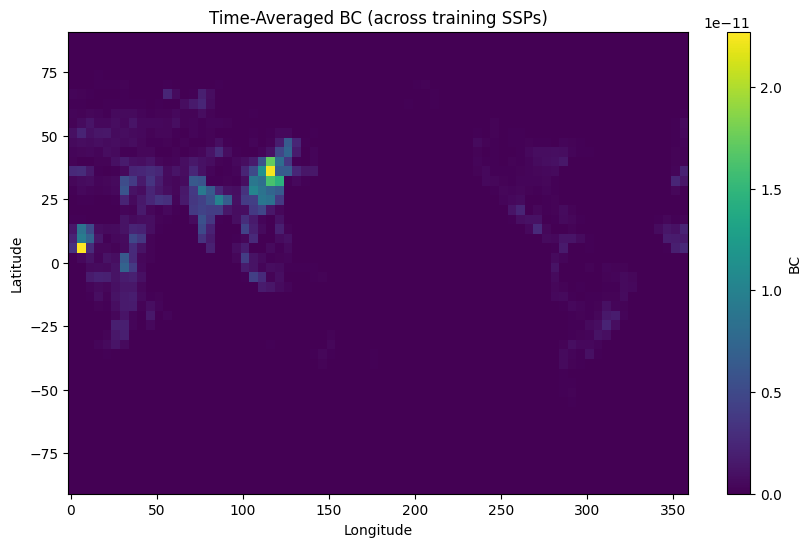

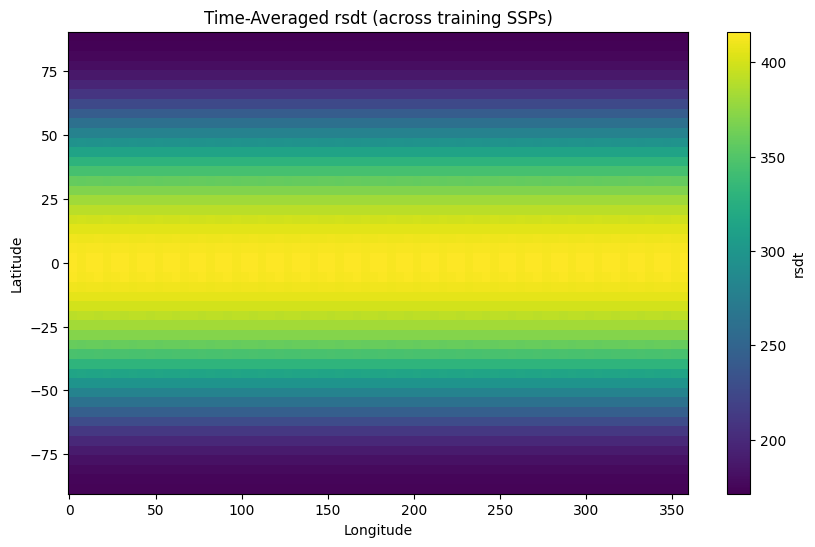

In [46]:
# Create spatial maps of time-averaged spatial input variables
if spatial_inputs:
    print("\n--- Plotting Spatial Input Variables (Time-Averaged Maps) ---")
    for var_name in spatial_inputs:
        try:
            # Select the variable and the training SSPs
            var_data_ssp_list = []
            for ssp in train_ssps:
                ssp_data = ds_raw[var_name].sel(ssp=ssp)
                if 'member_id' in ssp_data.dims: # Select target member
                    ssp_data = ssp_data.sel(member_id=target_member_id)
                var_data_ssp_list.append(ssp_data)
            
            # Concatenate along a new 'ssp_dim' if there are multiple SSPs, then average over ssp and time
            if len(var_data_ssp_list) > 1:
                var_data_combined = xr.concat(var_data_ssp_list, dim='ssp_dim')
                # Check if time dimension exists before trying to mean over it
                if 'time' in var_data_combined.dims:
                    time_averaged_var = var_data_combined.mean(dim=['ssp_dim', 'time'])
                else: # If no time dim, just mean over ssp_dim
                    time_averaged_var = var_data_combined.mean(dim='ssp_dim')
                    print(f"Warning: No 'time' dimension for {var_name} when combined. Averaging over SSPs only.")
            elif var_data_ssp_list: # Only one SSP, or variable doesn't have SSP dim
                # Check if time dimension exists
                if 'time' in var_data_ssp_list[0].dims:
                    time_averaged_var = var_data_ssp_list[0].mean(dim='time')
                else: # No time dimension, use as is (it might be static)
                    time_averaged_var = var_data_ssp_list[0]
                    print(f"Warning: No 'time' dimension for {var_name} in single SSP data. Using data as is for map.")
            else:
                print(f"No data found for {var_name} in train_ssps.")
                continue

            plt.figure(figsize=(10, 6))
            # Ensure coordinates are named consistently for plotting if possible
            if "latitude" in time_averaged_var.coords and "longitude" in time_averaged_var.coords:
                time_averaged_var = time_averaged_var.rename({'latitude':'y', 'longitude':'x'})
            
            time_averaged_var.plot(x='x', y='y', cmap='viridis') # Use 'x','y' if renamed, else auto
            plt.title(f'Time-Averaged {var_name} (across training SSPs)')
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.show()
        except Exception as e:
            print(f"Could not plot spatial map for {var_name}: {e}")
else:
    print("No spatial input variables identified to plot maps.")



--- Plotting Input Variable Histograms ---


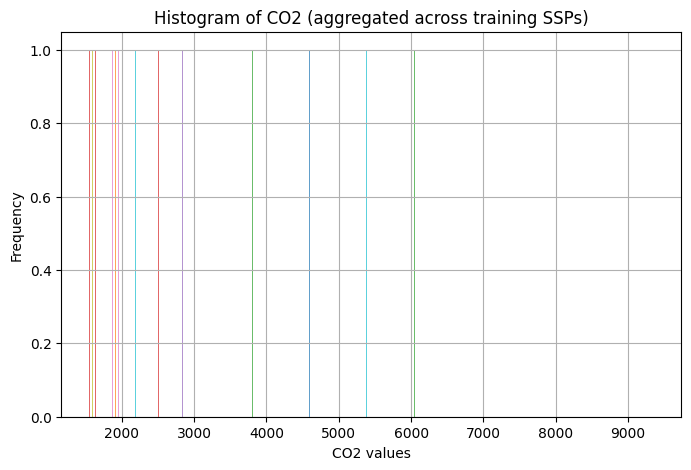

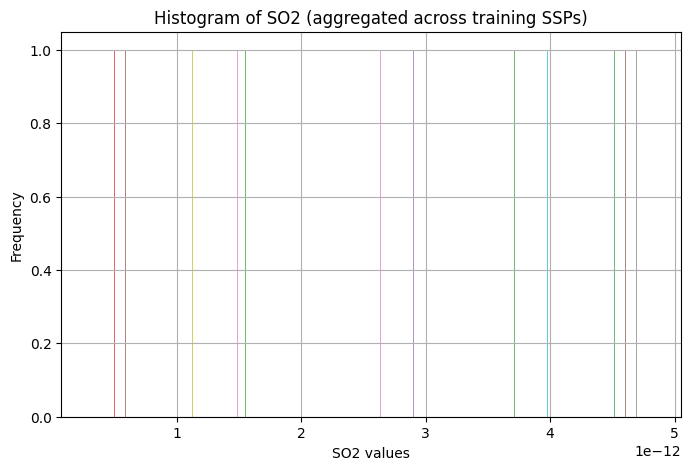

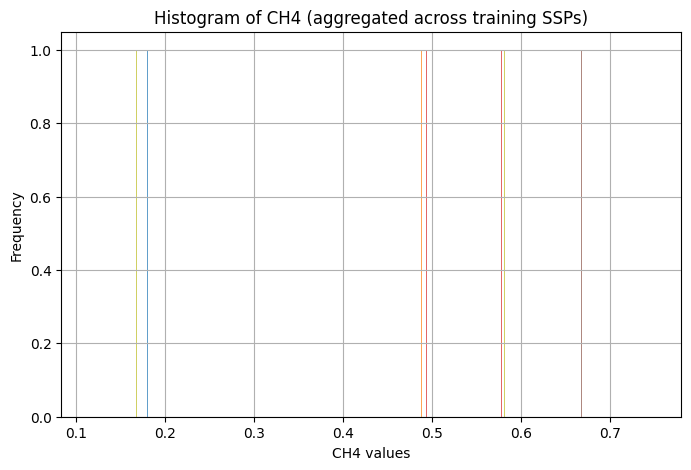

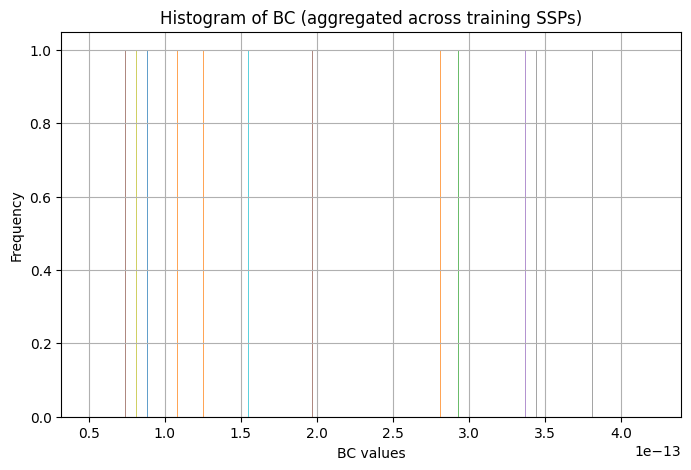

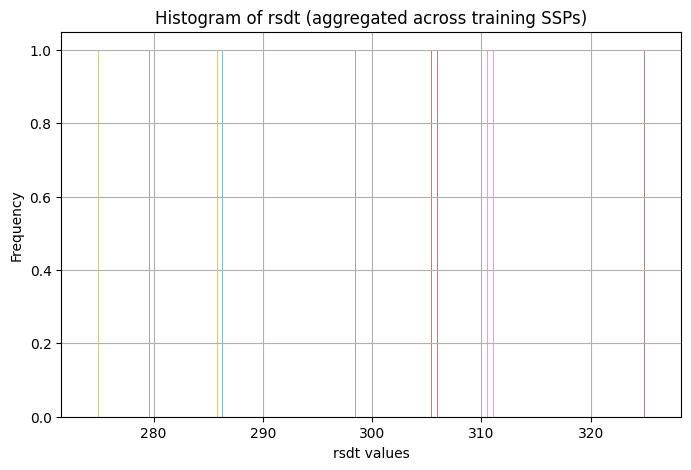

In [47]:
# Generate histograms for input variables
print("\n--- Plotting Input Variable Histograms ---")
for var_name in input_variables: # Iterate through all original input_vars
    try:
        plt.figure(figsize=(8, 5))
        all_ssp_data_for_hist = []
        for ssp in train_ssps:
            var_data_ssp = ds_raw[var_name].sel(ssp=ssp)
            if 'member_id' in var_data_ssp.dims:
                 var_data_ssp = var_data_ssp.sel(member_id=target_member_id)

            # If spatial, average over spatial dims. If only time, use as is.
            spatial_dims_present = any(d in var_data_ssp.dims for d in ['latitude', 'longitude', 'y', 'x', 'lat', 'lon'])
            if spatial_dims_present:
                mean_dims = [d for d in ['latitude', 'longitude', 'y', 'x', 'lat', 'lon'] if d in var_data_ssp.dims]
                if mean_dims: # Ensure there are spatial dimensions to average
                    data_for_hist = var_data_ssp.mean(dim=mean_dims).data.flatten()
                else: # Should not happen if spatial_dims_present is true and mean_dims is populated correctly
                    data_for_hist = var_data_ssp.data.flatten()
            else: # Non-spatial (e.g. only time dim or scalar per ssp)
                data_for_hist = var_data_ssp.data.flatten()
            
            all_ssp_data_for_hist.extend(data_for_hist)
        
        plt.hist(all_ssp_data_for_hist, bins=50, alpha=0.7)
        plt.title(f'Histogram of {var_name} (aggregated across training SSPs)')
        plt.xlabel(f'{var_name} values')
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Could not plot histogram for {var_name}: {e}")


In [48]:
# Report the calculated mean_in and std_in values from the normalizer
print("\n--- Normalization Statistics for Input Variables ---")
# Ensure datamodule.normalizer has been set by running datamodule.setup() in a previous cell
if hasattr(datamodule, 'normalizer') and datamodule.normalizer.mean_in is not None and datamodule.normalizer.std_in is not None:
    for i, var_name in enumerate(input_variables): # input_variables from Cell 1
        # mean_in and std_in have shape (1, num_input_vars, 1, 1)
        # So, access the specific variable's mean/std like this:
        mean_val = datamodule.normalizer.mean_in[0, i, 0, 0] 
        std_val = datamodule.normalizer.std_in[0, i, 0, 0]
        print(f"Input Variable: {var_name}")
        print(f"  Training Mean: {mean_val:.4f}") # Adjust formatting as needed
        print(f"  Training Std:  {std_val:.4f}")
else:
    print("Normalizer input statistics (mean_in, std_in) not available. Make sure datamodule.setup() has been run.")

print("\n--- Normalization Statistics for Output Variables ---")
if hasattr(datamodule, 'normalizer') and datamodule.normalizer.mean_out is not None and datamodule.normalizer.std_out is not None:
    output_vars_from_config = config["data"]["output_vars"]
    for i, var_name in enumerate(output_vars_from_config):
        mean_val = datamodule.normalizer.mean_out[0, i, 0, 0]
        std_val = datamodule.normalizer.std_out[0, i, 0, 0]
        print(f"Output Variable: {var_name}")
        print(f"  Training Mean: {mean_val:.4f}")
        print(f"  Training Std:  {std_val:.4f}")
else:
    print("Normalizer output statistics (mean_out, std_out) not available.")



--- Normalization Statistics for Input Variables ---
Input Variable: CO2
  Training Mean: 3427.2961
  Training Std:  1806.3424
Input Variable: SO2
  Training Mean: 0.0000
  Training Std:  0.0000
Input Variable: CH4
  Training Mean: 0.3927
  Training Std:  0.1659
Input Variable: BC
  Training Mean: 0.0000
  Training Std:  0.0000
Input Variable: rsdt
  Training Mean: 297.6600
  Training Std:  164.0963

--- Normalization Statistics for Output Variables ---
Output Variable: tas
  Training Mean: 280.6547
  Training Std:  20.9672
Output Variable: pr
  Training Mean: 2.5220
  Training Std:  2.9687


In [49]:
import xarray as xr
import os

# --- Configuration ---

# Path to your local ssp245 Zarr store
# This should be the full path to the .zarr directory/store.
ssp245_zarr_path = os.path.expanduser("~/Desktop/cse 151B/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr")

# Input variables as defined in your notebook's config that you want to check
# Based on your image, these are the data variables inside the Zarr store
input_vars_to_check = ["CO2", "SO2", "CH4", "BC", "rsdt"]
# Also including output variables as they are in the same Zarr store
output_vars_to_check = ["tas", "pr"]
all_vars_to_check = input_vars_to_check + output_vars_to_check

# --- Code to check units ---
print(f"Attempting to open Zarr dataset: {ssp245_zarr_path}\n")

if not os.path.exists(ssp245_zarr_path):
    print(f"ERROR: Zarr path does not exist: {ssp245_zarr_path}")
    print("Please double-check the path to your .zarr file.")
else:
    try:
        # consolidated=True is often recommended for performance with Zarr
        # For Zarr, the path is to the directory that acts as the store
        ds = xr.open_zarr(ssp245_zarr_path, consolidated=True)
        print(f"Successfully opened dataset: {ssp245_zarr_path}")
        
        print(f"\nAll Data Variables found in the Zarr store: {list(ds.data_vars)}")
        print("\n--- Attributes for Specified Variables ---")
        
        for var_name in all_vars_to_check:
            if var_name in ds:
                print(f"\n  Variable: {var_name}")
                units = ds[var_name].attrs.get('units', 'N/A (units attribute not found)')
                long_name = ds[var_name].attrs.get('long_name', 'N/A (long_name attribute not found)')
                standard_name = ds[var_name].attrs.get('standard_name', 'N/A (standard_name attribute not found)')
                
                print(f"    Units: {units}")
                print(f"    Long Name: {long_name}")
                print(f"    Standard Name: {standard_name}")
                # To see all attributes, you could uncomment the next line:
                # print(f"    All attributes: {ds[var_name].attrs}")
            elif var_name == "BC": # BC was not in the Zarr structure from the image
                print(f"\n  Variable: {var_name}")
                print(f"    Note: '{var_name}' was not listed in the Zarr structure from your image. It might be handled differently or be absent from the ssp245 file.")
            else:
                print(f"\n  Variable: {var_name} - Not found as a data variable in this Zarr store.")
        
        ds.close() # Close the dataset
        
    except Exception as e:
        print(f"  ERROR opening or processing {ssp245_zarr_path}: {e}")

print("\n" + "-" * 50)
print("Unit checking script finished.")
print("This script checked the metadata within your ssp245 Zarr file.")
print("The normalization statistics (mean/std) you obtained earlier in your notebook were calculated from the TRAINING SSP datasets (ssp126, ssp370, ssp585), not this ssp245 test file.")


Attempting to open Zarr dataset: /Users/wangxinheng/Desktop/cse 151B/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr

Successfully opened dataset: /Users/wangxinheng/Desktop/cse 151B/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr

All Data Variables found in the Zarr store: ['BC', 'CH4', 'CO2', 'SO2', 'pr', 'rsdt', 'tas']

--- Attributes for Specified Variables ---

  Variable: CO2
    Units: N/A (units attribute not found)
    Long Name: N/A (long_name attribute not found)
    Standard Name: N/A (standard_name attribute not found)

  Variable: SO2
    Units: N/A (units attribute not found)
    Long Name: N/A (long_name attribute not found)
    Standard Name: N/A (standard_name attribute not found)

  Variable: CH4
    Units: N/A (units attribute not found)
    Long Name: N/A (long_name attribute not found)
    Standard Name: N/A (standard

'config' dictionary found.
'ClimateDataModule' class found.
Attempting to instantiate and setup ClimateDataModule...
Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...
ClimateDataModule instantiated and setup successfully.
  Normalizer input means: [[[[3.42729610e+03]]

  [[2.68368806e-12]]

  [[3.92687065e-01]]

  [[2.28588613e-13]]

  [[2.97659975e+02]]]]
  Normalizer input stds: [[[[1.80634237e+03]]

  [[1.53819029e-11]]

  [[1.65853208e-01]]

  [[1.26186352e-12]]

  [[1.64096289e+02]]]]
  Latitude coordinates sample: [-88.58638743 -84.81675393 -81.04712042 -77.27748691 -73.5078534 ]

Attempting to open full Zarr dataset from: /Users/wangxinheng/Desktop/cse 151B/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr
Full Zarr dataset opened successfully.
  Available SSPs: [np.str_('ssp126'), np.str_('ssp245'), np.str_('ssp370'), np.str_('ssp585')]
  Availab

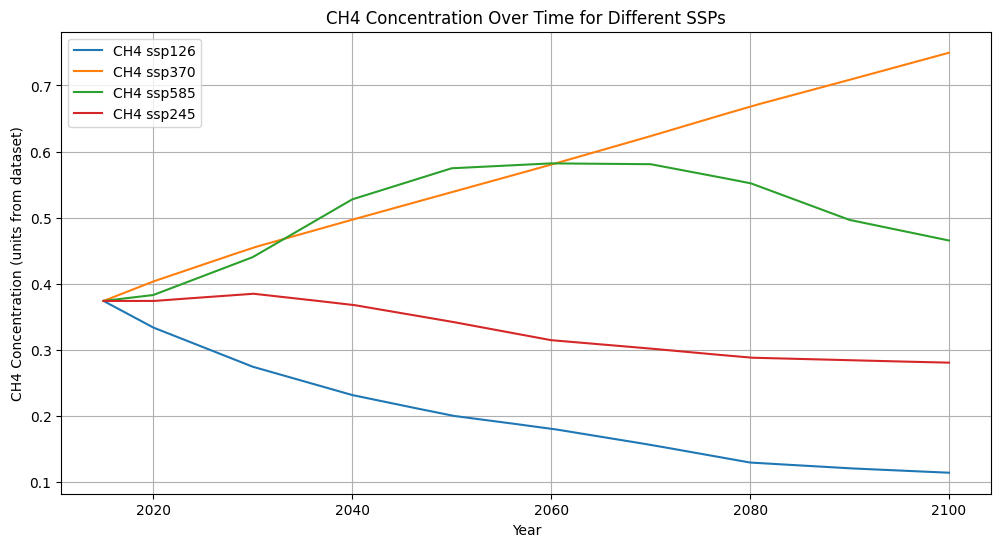


--- Generating Plot 2: Global Mean TAS trends (excluding ssp245) ---
Plotting Global Mean TAS for SSPs: ['ssp126', 'ssp370', 'ssp585']


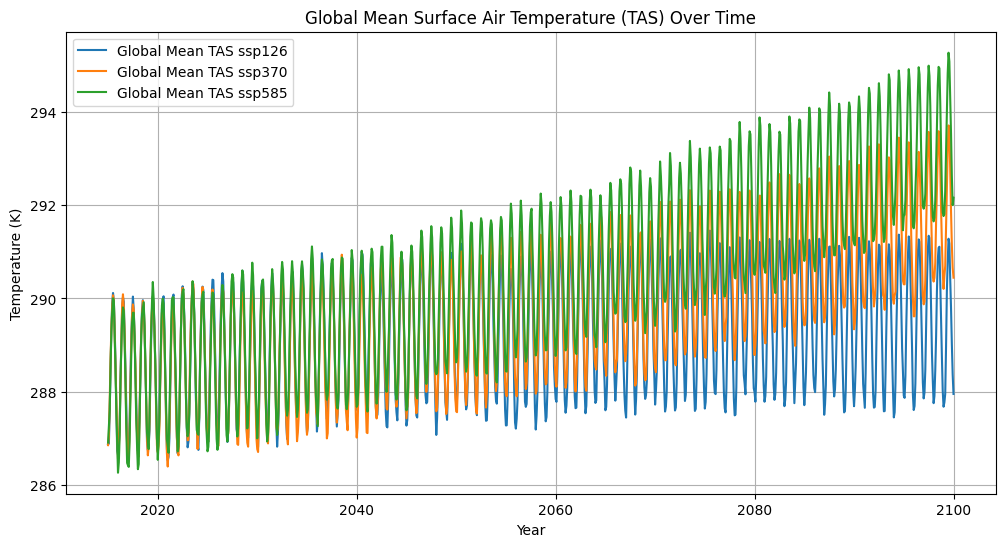

In [50]:
# CELL 1: Data Loading and Setup for Plotting

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'config' is defined (should be from a previous cell)
if 'config' not in globals():
    print("ERROR: 'config' dictionary not found. Please define it in a previous cell.")
    # You might want to raise an error here or define a default config for testing
else:
    print("'config' dictionary found.")

    # Ensure 'ClimateDataModule' class is defined (should be from a previous cell)
    if 'ClimateDataModule' not in globals():
        print("ERROR: 'ClimateDataModule' class definition not found. Please define it in a previous cell.")
    else:
        print("'ClimateDataModule' class found.")

        datamodule = None
        full_ds = None

        try:
            # 1. Instantiate and setup datamodule (if not already done by the trainer)
            # We do this to easily access normalizer, lat/lon, and specific splits if needed.
            print("Attempting to instantiate and setup ClimateDataModule...")
            datamodule = ClimateDataModule(**config["data"])
            datamodule.setup() # This loads data, calculates stats, creates train/val/test PyTorch datasets
            print("ClimateDataModule instantiated and setup successfully.")
            print(f"  Normalizer input means: {datamodule.normalizer.mean_in}")
            print(f"  Normalizer input stds: {datamodule.normalizer.std_in}")
            print(f"  Latitude coordinates sample: {datamodule.lat[:5]}")
        except Exception as e:
            print(f"ERROR during ClimateDataModule instantiation or setup: {e}")
            print("Proceeding with caution; some datamodule-dependent plots might fail.")

        try:
            # 2. Load the full Zarr dataset for flexible data exploration across all SSPs
            print(f"\nAttempting to open full Zarr dataset from: {config['data']['path']}")
            full_ds = xr.open_zarr(config['data']['path'], consolidated=False)
            print("Full Zarr dataset opened successfully.")
            print("  Available SSPs:", list(full_ds.ssp.values))
            print("  Available variables:", list(full_ds.data_vars.keys()))
            print(f"  Time dimension size: {full_ds.time.size}")

        except FileNotFoundError:
            print(f"ERROR: Zarr dataset not found at path: {config['data']['path']}")
        except Exception as e:
            print(f"ERROR opening full Zarr dataset: {e}")

# Now, for the plots you requested:

# Plot 1: Comparison of CH4 concentration across different SSP scenarios over time.
# For this, we should use 'full_ds' as it contains all SSPs.
print("\n--- Generating Plot 1: CH4 concentrations across SSPs ---")
if full_ds is not None and 'CH4' in full_ds:
    try:
        plt.figure(figsize=(12, 6))
        # Plot CH4 for each SSP present in your training configuration
        # and the test SSP if you want to include it (as CH4 for ssp245 should be valid).
        spps_to_plot = config['data']['train_ssps'] + [config['data']['test_ssp']]
        
        for ssp_name in spps_to_plot:
            if ssp_name in full_ds.ssp.values:
                # CH4, like CO2, is often treated as non-spatial (global mean over time per SSP)
                # in these types of aggregated datasets.
                ch4_data = full_ds['CH4'].sel(ssp=ssp_name)
                
                # Create a time axis in years from the start of the simulation
                time_axis_months = np.arange(len(ch4_data.time))
                time_axis_years = 2015 + time_axis_months / 12 # Assuming start year 2015

                plt.plot(time_axis_years, ch4_data.data, label=f'CH4 {ssp_name}')
            else:
                print(f"SSP {ssp_name} not found in full_ds. Skipping for CH4 plot.")
        
        plt.title('CH4 Concentration Over Time for Different SSPs')
        plt.xlabel('Year')
        plt.ylabel('CH4 Concentration (units from dataset)') # Update units if known, often ppb or ppm
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error generating CH4 plot: {e}")
        import traceback
        traceback.print_exc()
else:
    if full_ds is None:
         print("Skipping CH4 plot: 'full_ds' is not loaded.")
    elif 'CH4' not in full_ds:
        print("Skipping CH4 plot: 'CH4' variable is missing in 'full_ds'.")


# Plot 2: Temporal trend of global mean 'tas' over available years in one or more SSP scenarios.
# Modified to exclude ssp245 (the test_ssp) from this particular visualization.
print("\n--- Generating Plot 2: Global Mean TAS trends (excluding ssp245) ---")

# Define get_lat_weights locally in this cell for robustness
def get_lat_weights(latitude_values):
    """Computes cosine-based area weights for each latitude."""
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

# Check if full_ds is loaded, 'tas' variable exists, 
# and 'y' & 'x' are coordinates/dimensions in full_ds that 'tas' uses.
if full_ds is not None and 'tas' in full_ds and \
   'y' in full_ds.coords and 'x' in full_ds.coords: 
    try:
        plt.figure(figsize=(12, 6))
        # Only plot the training SSPs for this visualization
        spps_to_plot = config['data']['train_ssps'] 
        print(f"Plotting Global Mean TAS for SSPs: {spps_to_plot}")
        
        area_weights_for_plot = xr.DataArray(
            get_lat_weights(full_ds.y.values),
            dims=['y'],
            coords={'y': full_ds.y.values}
        )
        # print("Successfully calculated area_weights_for_plot using full_ds.y and dimension 'y'.") # Less verbose

        for ssp_name in spps_to_plot:
            if ssp_name in full_ds.ssp.values:
                tas_ssp = full_ds['tas'].sel(ssp=ssp_name, member_id=config['data']['target_member_id'])
                
                spatial_dims_present = [d for d in ['y', 'x'] if d in tas_ssp.dims]
                
                if area_weights_for_plot is not None and 'y' in spatial_dims_present \
                    and tas_ssp.y.shape == area_weights_for_plot.y.shape: 
                    global_mean_tas = tas_ssp.weighted(area_weights_for_plot).mean(dim=spatial_dims_present)
                    # print(f"Applied weighted mean for TAS in {ssp_name} using dimensions {spatial_dims_present}.") # Less verbose
                else:
                    # Fallback, with minimal printing unless error
                    mean_dims = [d for d in ['y', 'x'] if d in tas_ssp.dims] 
                    if not mean_dims:
                        print(f"Error: No recognized spatial dimensions ('y', 'x') found in tas_ssp for {ssp_name} to take a mean.")
                        continue 
                    global_mean_tas = tas_ssp.mean(dim=mean_dims)
                    print(f"  Using unweighted mean for {ssp_name} over dimensions: {mean_dims}")

                # --- Debug block for ssp245 is removed as we are not plotting it ---

                time_axis_months = np.arange(len(global_mean_tas.time))
                time_axis_years = 2015 + time_axis_months / 12 
                
                plt.plot(time_axis_years, global_mean_tas.data, label=f'Global Mean TAS {ssp_name}')
            else:
                print(f"SSP {ssp_name} not found in full_ds. Skipping for TAS plot.")
                
        plt.title('Global Mean Surface Air Temperature (TAS) Over Time')
        plt.xlabel('Year')
        plt.ylabel('Temperature (K)') 
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error generating TAS plot: {e}")
        import traceback
        traceback.print_exc() 
else:
    if full_ds is None:
        print("Skipping TAS plot: 'full_ds' is not loaded.")
    elif 'tas' not in full_ds:
        print("Skipping TAS plot: 'tas' variable is missing in 'full_ds'.")
    elif not ('y' in full_ds.coords and 'x' in full_ds.coords):
        print("Skipping TAS plot: 'y' or 'x' coordinates missing in 'full_ds' itself.")



--- Analyzing Correlations Between Input and Output Variables (Training SSPs) ---
Using SSPs for training correlation analysis: ['ssp126', 'ssp370', 'ssp585']

Global mean data prepared for correlation (first 5 rows):
      ssp          CO2  SO2       CH4  BC        rsdt         tas        pr
0  ssp126  1536.072222  NaN  0.373737 NaN  351.520198  286.867587  2.908672
1  ssp126  1539.115681  NaN  0.373053 NaN  348.745214  286.883292  3.046570
2  ssp126  1541.864611  NaN  0.372436 NaN  343.799945  287.589466  2.910515
3  ssp126  1544.908070  NaN  0.371752 NaN  337.927524  288.408687  2.995516
4  ssp126  1547.853352  NaN  0.371091 NaN  332.919688  289.334473  2.998603


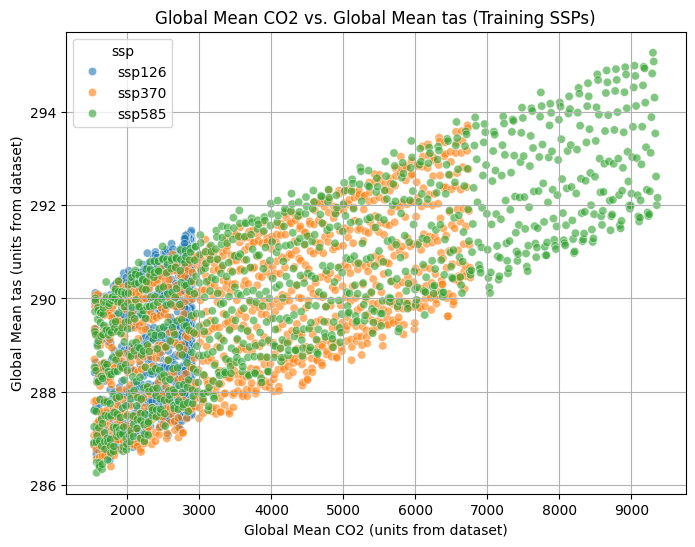

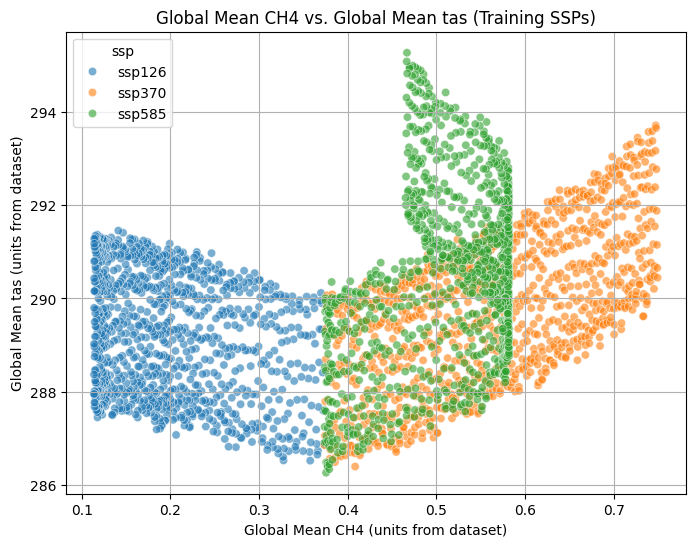

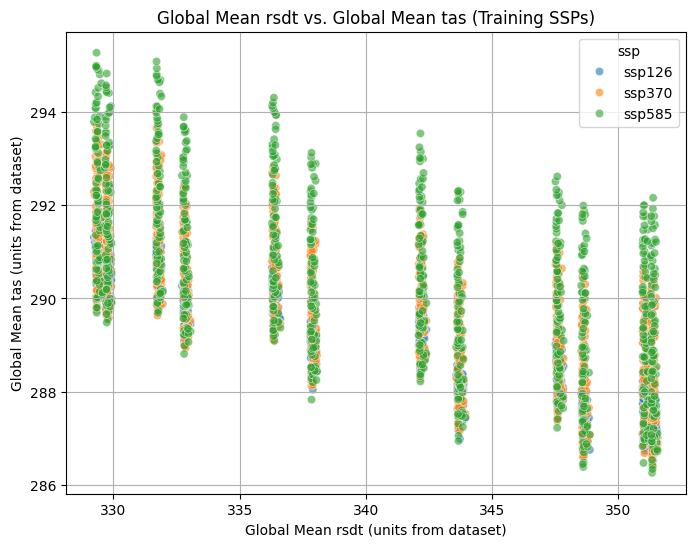


Correlation Matrix (Training SSPs, Global Means):
           CO2       CH4      rsdt       tas        pr
CO2   1.000000  0.549586 -0.000137  0.696219  0.580225
CH4   0.549586  1.000000 -0.000237  0.346149  0.106290
rsdt -0.000137 -0.000237  1.000000 -0.676330 -0.387691
tas   0.696219  0.346149 -0.676330  1.000000  0.710162
pr    0.580225  0.106290 -0.387691  0.710162  1.000000


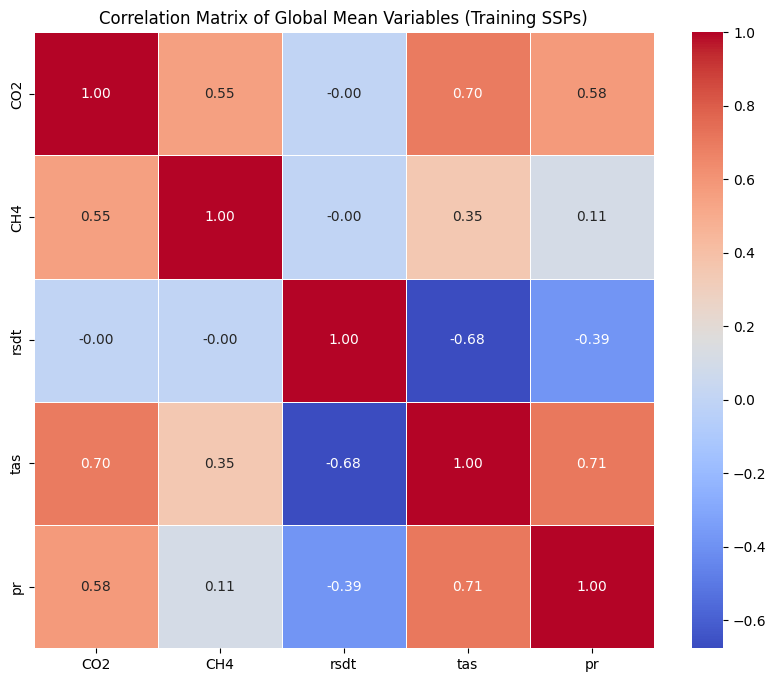


--- Correlation analysis script finished ---


In [51]:
# CELL: Correlations Between Input and Output Variables

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # For heatmap

print("\n--- Analyzing Correlations Between Input and Output Variables (Training SSPs) ---")

# Ensure 'full_ds' and 'config' are available
if 'full_ds' not in globals() or full_ds is None:
    print("ERROR: 'full_ds' not found or not loaded. Please run the data loading cell first.")
elif 'config' not in globals():
    print("ERROR: 'config' dictionary not found. Please define it first.")
else:
    try:
        train_spps = config['data']['train_ssps']
        input_vars = config['data']['input_vars']
        output_vars = config['data']['output_vars']
        target_member_id = config['data']['target_member_id']

        # Helper function for area weights (ensure it's defined)
        # def get_lat_weights(latitude_values):
        #     lat_rad = np.deg2rad(latitude_values)
        #     weights = np.cos(lat_rad)
        #     return weights / np.mean(weights)

        # Assuming 'y' is the latitude coordinate name in full_ds, as confirmed before
        if 'y' not in full_ds.coords:
            raise ValueError("'y' coordinate (latitude) not found in full_ds. Cannot calculate area weights.")
        
        area_weights = xr.DataArray(
            get_lat_weights(full_ds.y.values),
            dims=['y'],
            coords={'y': full_ds.y.values}
        )
        print(f"Using SSPs for training correlation analysis: {train_spps}")

        # --- 1. Prepare data: Calculate global means for all relevant variables from training SSPs ---
        global_mean_data_list = []

        for ssp_name in train_spps:
            if ssp_name not in full_ds.ssp.values:
                print(f"Warning: SSP {ssp_name} not found in full_ds. Skipping.")
                continue

            ssp_data_dict = {'ssp': ssp_name}
            
            # Process input variables
            for var_name in input_vars:
                if var_name in full_ds:
                    data_array = full_ds[var_name].sel(ssp=ssp_name)
                    if 'member_id' in data_array.dims and var_name not in ['CO2', 'CH4']: # CO2, CH4 might not have member_id
                         data_array = data_array.sel(member_id=target_member_id)

                    if set(data_array.dims) == {'time'}: # Non-spatial (e.g., CO2, CH4)
                        ssp_data_dict[var_name] = data_array.data
                    elif {'y', 'x'}.issubset(set(data_array.dims)): # Spatial (e.g., rsdt, SO2, BC)
                        weighted_mean = data_array.weighted(area_weights).mean(dim=['x', 'y'])
                        ssp_data_dict[var_name] = weighted_mean.data
                    else:
                        print(f"Warning: Variable {var_name} in {ssp_name} is not purely temporal or spatial (dims: {data_array.dims}). Skipping.")
                        ssp_data_dict[var_name] = np.full(full_ds.time.size, np.nan) # Placeholder
                else:
                    print(f"Warning: Input variable {var_name} not found in full_ds. Skipping.")
                    ssp_data_dict[var_name] = np.full(full_ds.time.size, np.nan)


            # Process output variables (tas, pr)
            for var_name in output_vars:
                if var_name in full_ds:
                    data_array = full_ds[var_name].sel(ssp=ssp_name, member_id=target_member_id)
                    if {'y', 'x'}.issubset(set(data_array.dims)):
                        weighted_mean = data_array.weighted(area_weights).mean(dim=['x', 'y'])
                        ssp_data_dict[var_name] = weighted_mean.data
                    else:
                        print(f"Warning: Output variable {var_name} in {ssp_name} is not spatial (dims: {data_array.dims}). Skipping global mean.")
                        ssp_data_dict[var_name] = np.full(full_ds.time.size, np.nan)

                else:
                    print(f"Warning: Output variable {var_name} not found in full_ds. Skipping.")
                    ssp_data_dict[var_name] = np.full(full_ds.time.size, np.nan)
            
            # Assuming all data_arrays for a given ssp have the same time length
            # Find a valid data array to get the time length
            example_var = next((ssp_data_dict[v] for v in input_vars + output_vars if isinstance(ssp_data_dict.get(v), np.ndarray)), None)
            if example_var is not None:
                 num_timesteps = len(example_var)
                 # Ensure all arrays have the same length for DataFrame creation
                 for key, val in ssp_data_dict.items():
                     if isinstance(val, np.ndarray) and len(val) != num_timesteps:
                         print(f"Warning: Length mismatch for {key} in {ssp_name}. Expected {num_timesteps}, got {len(val)}. Filling with NaNs.")
                         ssp_data_dict[key] = np.full(num_timesteps, np.nan)

                 global_mean_data_list.append(pd.DataFrame(ssp_data_dict))


        if not global_mean_data_list:
            raise ValueError("No data processed for correlation analysis. Check SSP names and variable availability.")

        combined_gm_data = pd.concat(global_mean_data_list, ignore_index=True)
        print("\nGlobal mean data prepared for correlation (first 5 rows):")
        print(combined_gm_data.head())

        # --- 2. Scatter Plots ---
        scatter_pairs = [('CO2', 'tas'), ('CH4', 'tas'), ('rsdt', 'tas')]
        
        for x_var, y_var in scatter_pairs:
            if x_var in combined_gm_data.columns and y_var in combined_gm_data.columns:
                plt.figure(figsize=(8, 6))
                sns.scatterplot(data=combined_gm_data, x=x_var, y=y_var, hue='ssp', alpha=0.6)
                plt.title(f'Global Mean {x_var} vs. Global Mean {y_var} (Training SSPs)')
                plt.xlabel(f'Global Mean {x_var} (units from dataset)')
                plt.ylabel(f'Global Mean {y_var} (units from dataset)')
                plt.grid(True)
                plt.show()
            else:
                print(f"\nWarning: Cannot create scatter plot for {x_var} vs {y_var}. One or both variables missing from processed data.")
                if x_var not in combined_gm_data.columns: print(f"Missing: {x_var}")
                if y_var not in combined_gm_data.columns: print(f"Missing: {y_var}")


        # --- 3. Correlation Matrix Heatmap ---
        # Select only numeric columns for correlation (all our processed global means should be)
        numeric_cols_for_corr = input_vars + output_vars
        # Filter out columns that might not have been processed correctly (e.g., all NaNs if a var was missing)
        valid_cols_for_corr = [col for col in numeric_cols_for_corr if col in combined_gm_data.columns and combined_gm_data[col].notna().any()]
        
        if not valid_cols_for_corr:
             print("\nWarning: No valid numeric columns found for correlation matrix. Skipping heatmap.")
        else:
            correlation_matrix = combined_gm_data[valid_cols_for_corr].corr()
            print("\nCorrelation Matrix (Training SSPs, Global Means):")
            print(correlation_matrix)

            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
            plt.title('Correlation Matrix of Global Mean Variables (Training SSPs)')
            plt.show()

    except Exception as e:
        print(f"An error occurred during correlation analysis: {e}")
        import traceback
        traceback.print_exc()

print("\n--- Correlation analysis script finished ---")

In [52]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd

# --- Configuration (ensure this matches your notebook's setup) ---
# Make sure your 'config' dictionary is defined in your notebook,
# especially config['logging']['log_dir'] and paths to your data/model.
# Example:
# log_dir = config['logging']['log_dir']
# model_checkpoint_path = trainer.checkpoint_callback.best_model_path # If you have it

# --- Helper function to load data from TensorBoard logs ---
def load_tensorboard_logs(log_dir, scalar_tags):
    """
    Loads specified scalar data from TensorBoard event files.
    Args:
        log_dir (str): Path to the TensorBoard log directory (e.g., 'lightning_logs/version_X').
        scalar_tags (list): A list of scalar tags to extract (e.g., ['train/loss', 'val/tas/time_mean_rmse']).
    Returns:
        dict: A dictionary where keys are tags and values are lists of (step, value) tuples.
    """
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload() # Load all data from events.out.tfevents file

    data = {}
    for tag in scalar_tags:
        if tag in event_acc.Tags()['scalars']:
            events = event_acc.Scalars(tag)
            data[tag] = [(event.step, event.value) for event in events]
        else:
            print(f"Warning: Tag '{tag}' not found in TensorBoard logs at {log_dir}")
            data[tag] = []
    return data

# --- Denormalization (ensure your data_module and normalizer are accessible) ---
# Assuming 'data_module' is already set up and has the normalizer
# normalizer = data_module.normalizer
# Or, if you need to re-initialize:
# data_module = ClimateDataModule(config) # Or however you initialize it
# data_module.setup(stage='fit') # or 'test' or 'predict'
# normalizer = data_module.normalizer

# Placeholder for normalizer if not defined yet - replace with your actual normalizer
class PlaceholderNormalizer:
    def denormalize_input(self, tensor, var_name):
        print(f"Placeholder denormalize_input for {var_name}. Implement actual denormalization.")
        return tensor # return as is
    def denormalize_output(self, tensor, var_name):
        print(f"Placeholder denormalize_output for {var_name}. Implement actual denormalization.")
        return tensor # return as is

# Attempt to get the normalizer. If not available or not set up, try to initialize it.
normalizer = None  # Initialize to None
try:
    # Check if data_module exists and its normalizer is properly set up
    if 'data_module' in globals() and \
       data_module is not None and \
       hasattr(data_module, 'normalizer') and \
       data_module.normalizer is not None and \
       hasattr(data_module.normalizer, 'mean_in') and \
       data_module.normalizer.mean_in is not None: # A good check for setup
        normalizer = data_module.normalizer
        print("Using normalizer from existing 'data_module'.")
    else:
        # Try to initialize it if 'config' and 'ClimateDataModule' are available
        if 'config' in globals() and 'ClimateDataModule' in globals():
            print("Attempting to initialize 'data_module' and 'normalizer' for this cell...")
            # Create a temporary datamodule instance for this cell's scope
            # Or, if you intend for this cell to make 'data_module' global, you can assign to global 'data_module'
            temp_dm_for_cell = ClimateDataModule(**config["data"])
            temp_dm_for_cell.setup() # This will set up the normalizer inside temp_dm_for_cell
            normalizer = temp_dm_for_cell.normalizer
            # If you want subsequent code in THIS CELL to also use this specific 'data_module' instance:
            # data_module = temp_dm_for_cell
            print("Successfully initialized 'normalizer' from a new 'data_module' instance for this cell.")
        else:
            print("Warning: 'config' or 'ClimateDataModule' class not found. Cannot initialize a new normalizer.")
            # normalizer remains None here, will be caught by the final check
            pass # Python requires at least one statement in an else block if not assigning to normalizer

except Exception as e:
    print(f"Error during normalizer setup: {e}. Using placeholder.")
    # normalizer remains None or its previous state, will be caught

# Final fallback if normalizer is still not set
if normalizer is None:
    print("Using placeholder normalizer as a fallback.")
    normalizer = PlaceholderNormalizer()


# --- Ensure model is loaded and in eval mode ---
# Assuming 'model' is your trained PyTorch Lightning model
# Example:
# model = ClimateEmulationModule.load_from_checkpoint(model_checkpoint_path, config=config)
# model.eval()
# if torch.cuda.is_available(): # Or use MPS if that's your setup
#    model.cuda()

# Placeholder for model if not defined yet - replace with your actual model loading
try:
    if 'model' in globals() and hasattr(model, 'eval'):
        model.eval()
        print("Using existing 'model' and setting to eval mode.")
    else:
        print("Warning: Trained 'model' not found. Visualization of high-error samples will not work correctly.")
        print("Please load your trained model, e.g., model = ClimateEmulationModule.load_from_checkpoint(...) and ensure it's in eval mode.")
        model = None # Placeholder
except NameError:
    print("Warning: Trained 'model' not defined. Visualization of high-error samples will not work correctly.")
    print("Please load your trained model, e.g., model = ClimateEmulationModule.load_from_checkpoint(...) and ensure it's in eval mode.")
    model = None # Placeholder

# Define input and output variable names based on your config
# Ensure 'config' is defined
try:
    input_vars = config['data']['input_vars']
    output_vars = config['data']['output_vars']
    lat_dim = 'y' # Should be 'y' after rename in datamodule
    lon_dim = 'x' # Should be 'x' after rename in datamodule
except NameError:
    print("Error: 'config' dictionary not defined. Please define it with your experiment settings.")
    input_vars = ['CO2', 'SO2', 'CH4', 'BC', 'rsdt'] # Defaults
    output_vars = ['tas', 'pr'] # Defaults
    lat_dim = 'y'
    lon_dim = 'x'


print("Setup cell executed. Ensure 'config', 'data_module', and 'model' are correctly defined and loaded if you see warnings.")

Attempting to initialize 'data_module' and 'normalizer' for this cell...
Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...
Successfully initialized 'normalizer' from a new 'data_module' instance for this cell.
Using existing 'model' and setting to eval mode.
Setup cell executed. Ensure 'config', 'data_module', and 'model' are correctly defined and loaded if you see warnings.


Loading metrics from: lightning_logs/version_7/metrics.csv


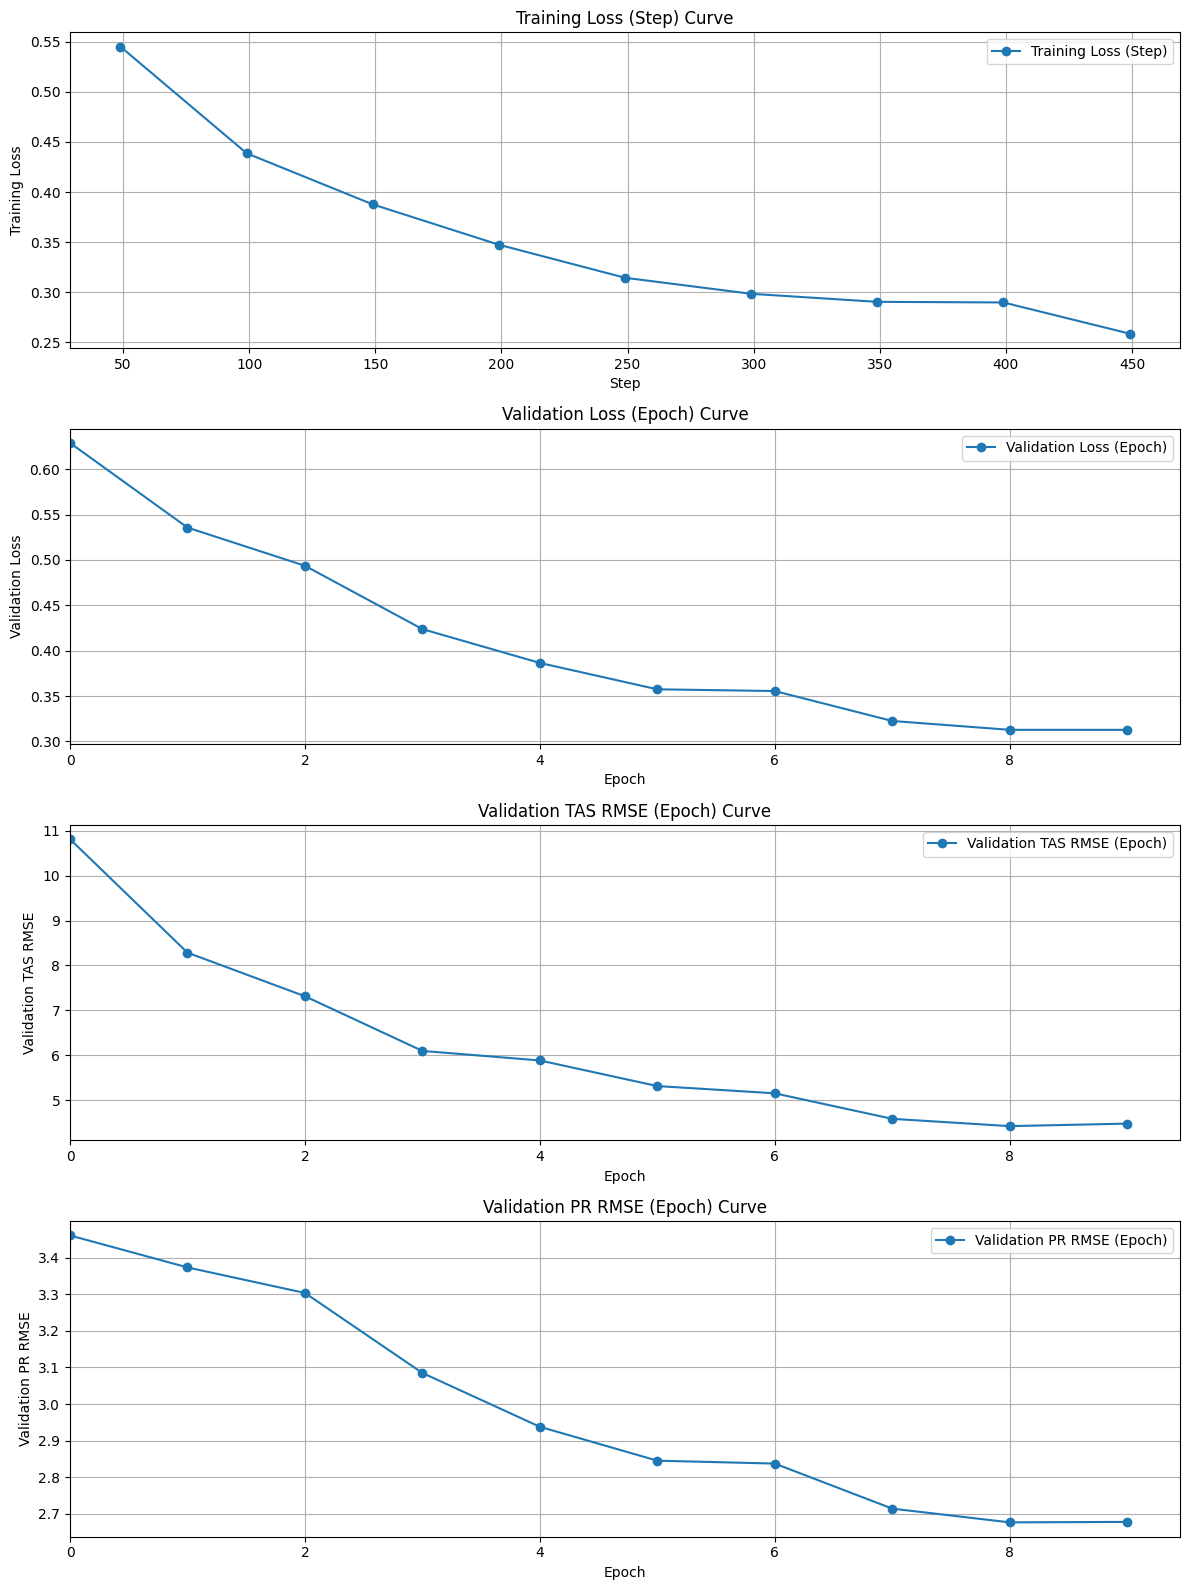

Loss curves plot saved to: loss_curves_from_csv.png


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np # Ensure numpy is imported

# --- Configuration ---
# >>> IMPORTANT: Verify this log_dir path. It's based on 'v_num=7' from your training output.
log_dir = "lightning_logs/version_7" # Or "lightning_logs/version_X"
metrics_file_path = os.path.join(log_dir, "metrics.csv")

# Columns to plot from metrics.csv
# Map: Display Name in Plot -> Column Name in CSV
cols_to_plot = {
    "Training Loss (Step)": "train/loss", # This is actually logged at the end of an epoch in metrics.csv, associated with a step
    "Validation Loss (Epoch)": "val/loss",
    "Validation TAS RMSE (Epoch)": "val/tas/rmse",
    "Validation PR RMSE (Epoch)": "val/pr/rmse"
}

# --- Load and Plot from CSV ---
if not os.path.exists(metrics_file_path):
    print(f"ERROR: Metrics CSV file not found: {metrics_file_path}")
    print("Please ensure the path is correct or that CSV logging was enabled and ran.")
else:
    print(f"Loading metrics from: {metrics_file_path}")
    try:
        df_metrics = pd.read_csv(metrics_file_path)

        # Prepare data for plotting
        plot_data = {}
        for display_name, csv_col_name in cols_to_plot.items():
            if csv_col_name in df_metrics.columns:
                # For step-based metrics like 'train/loss', we need 'step' as x-axis
                # For epoch-based metrics like 'val/loss', 'val/tas/rmse', we use 'epoch' as x-axis
                # We need to handle NaNs because not all metrics are logged at every row (e.g., test metrics only at the end)
                
                relevant_df = df_metrics[['epoch', 'step', csv_col_name]].dropna(subset=[csv_col_name])
                
                if "Step" in display_name: # Typically train/loss
                    # 'train/loss' in metrics.csv is logged per epoch, but associated with the last step of that epoch.
                    # If you want true per-step logging, TensorBoard events or custom logging is better.
                    # For now, we'll plot it against the step number it's logged with.
                    steps = relevant_df['step'].values
                    values = relevant_df[csv_col_name].values
                    # Sort by step if not already, just in case
                    sort_idx = np.argsort(steps)
                    plot_data[display_name] = {"x_values": steps[sort_idx], "y_values": values[sort_idx], "x_label": "Step"}

                elif "Epoch" in display_name: # Typically validation metrics
                    # Aggregate if multiple entries per epoch (e.g. if val_check_interval < 1.0 and multiple val loops per training epoch)
                    # For simplicity, if logged once per epoch, this will work directly.
                    # If logged multiple times per epoch, this takes the last logged value for that epoch.
                    epoch_data = relevant_df.groupby('epoch')[csv_col_name].last().reset_index() # Get last recorded value for epoch
                    plot_data[display_name] = {"x_values": epoch_data['epoch'].values, 
                                               "y_values": epoch_data[csv_col_name].values, 
                                               "x_label": "Epoch"}
            else:
                print(f"Warning: Column '{csv_col_name}' (for {display_name}) not found in {metrics_file_path}")
                plot_data[display_name] = {"x_values": [], "y_values": [], "x_label": "N/A"}


        num_plots = len([pd for pd_name, pd_data in plot_data.items() if len(pd_data["x_values"]) > 0])
        if num_plots > 0:
            fig, axs = plt.subplots(num_plots, 1, figsize=(12, 4 * num_plots), sharex=False)
            if num_plots == 1: axs = [axs] # Make axs iterable

            plot_idx = 0
            for display_name, data_dict in plot_data.items():
                if data_dict["x_values"].any(): # Check if data was loaded
                    ax = axs[plot_idx]
                    ax.plot(data_dict["x_values"], data_dict["y_values"], marker='o', linestyle='-', label=display_name)
                    ax.set_xlabel(data_dict["x_label"])
                    ax.set_ylabel(display_name.split('(')[0].strip())
                    ax.set_title(f"{display_name} Curve")
                    ax.legend()
                    ax.grid(True)
                    # Ensure x-axis starts from a sensible point (e.g. 0 or min value)
                    if data_dict["x_label"] == "Epoch":
                         ax.set_xlim(left=max(0, data_dict["x_values"].min() -1) ) # Start epoch from 0 or just before min
                         ax.xaxis.get_major_locator().set_params(integer=True) # Ensure integer epoch numbers

                    plot_idx += 1
                else:
                    if num_plots >1 : fig.delaxes(axs[plot_idx]) # clean up unused subplot


            plt.tight_layout()
            plt.show()
            
            fig_path_loss_curves = "loss_curves_from_csv.png"
            fig.savefig(fig_path_loss_curves)
            print(f"Loss curves plot saved to: {fig_path_loss_curves}")
        else:
            print("No data loaded for plotting. Check column names and CSV file content.")
            
    except Exception as e:
        print(f"Error reading or processing {metrics_file_path}: {e}")
        import traceback
        traceback.print_exc()

Calculating errors on the training set (this might take a while)...
  Processed batch 1/43
  Processed batch 11/43
  Processed batch 21/43
  Processed batch 31/43
  Processed batch 41/43
Error calculation finished.

--- Top 3 High-Error Training Samples for Variable: TAS ---


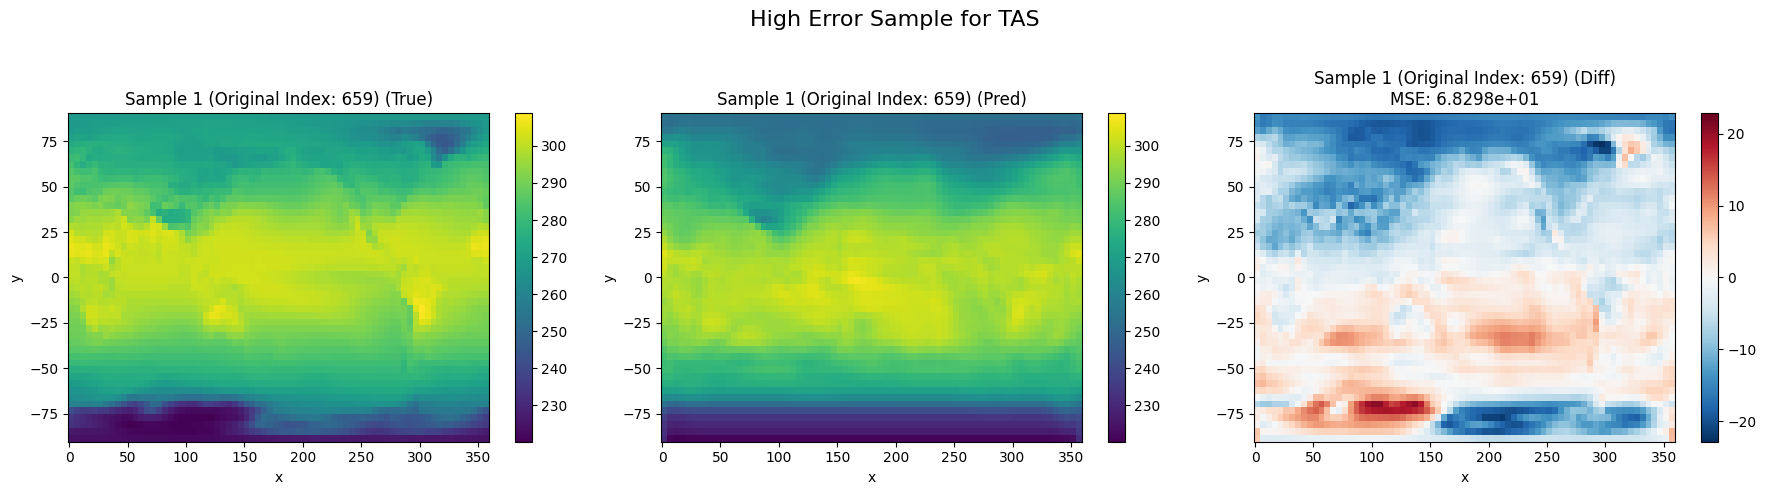

High-error sample plot saved to: high_error_sample_tas_1.png


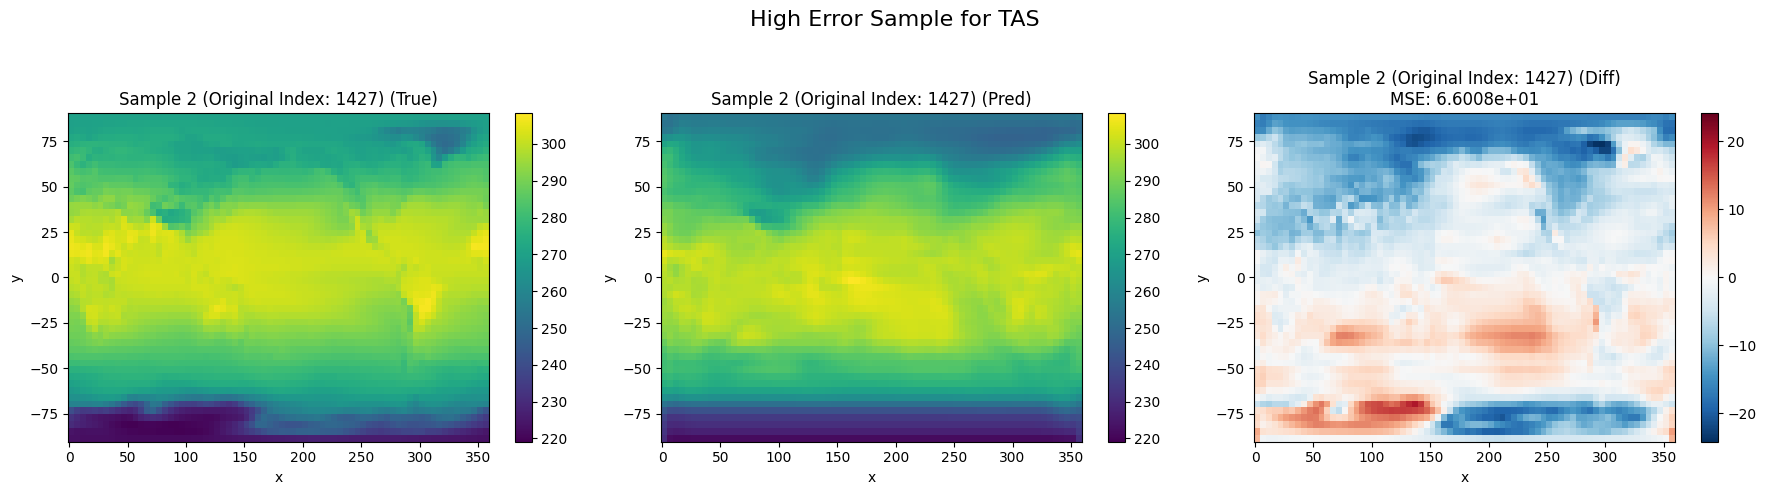

High-error sample plot saved to: high_error_sample_tas_2.png


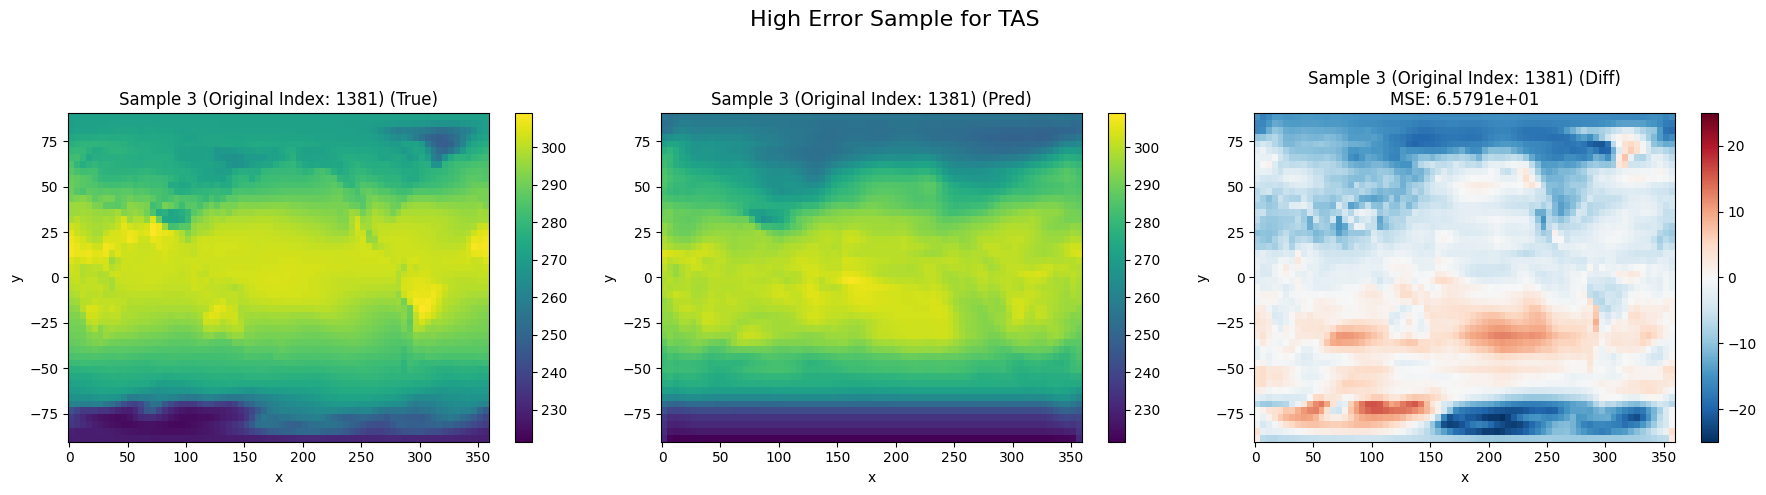

High-error sample plot saved to: high_error_sample_tas_3.png

--- Top 3 High-Error Training Samples for Variable: PR ---


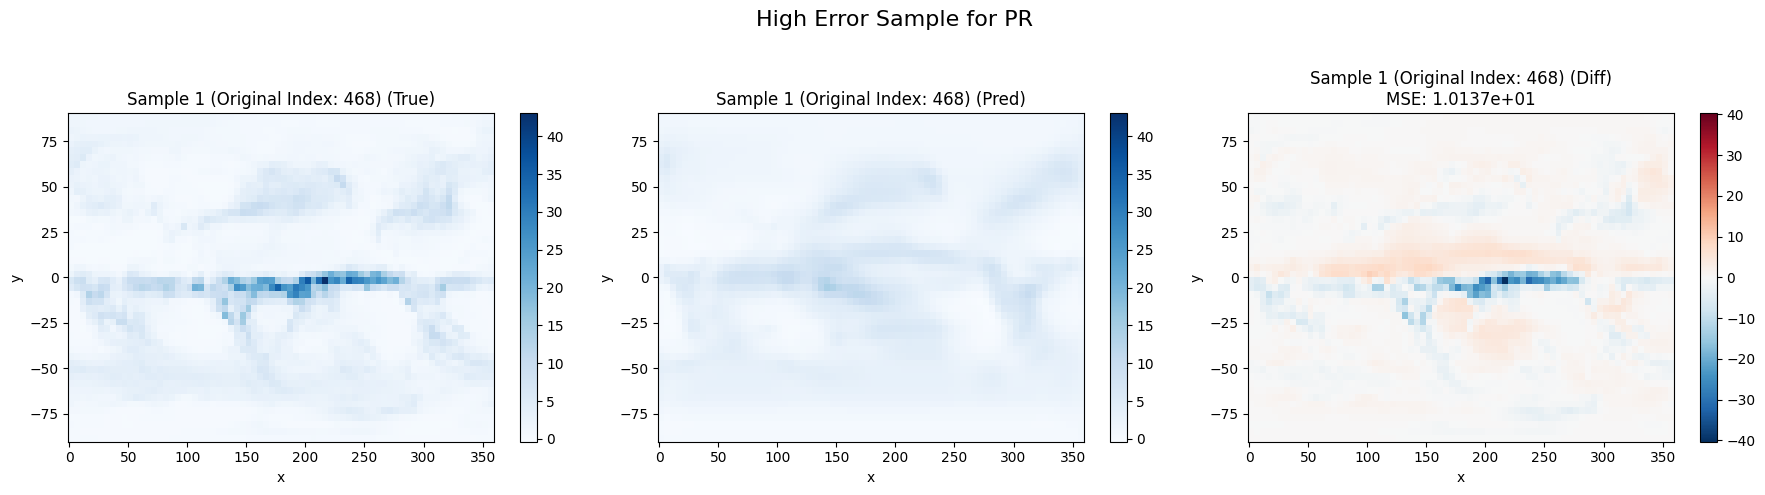

High-error sample plot saved to: high_error_sample_pr_1.png


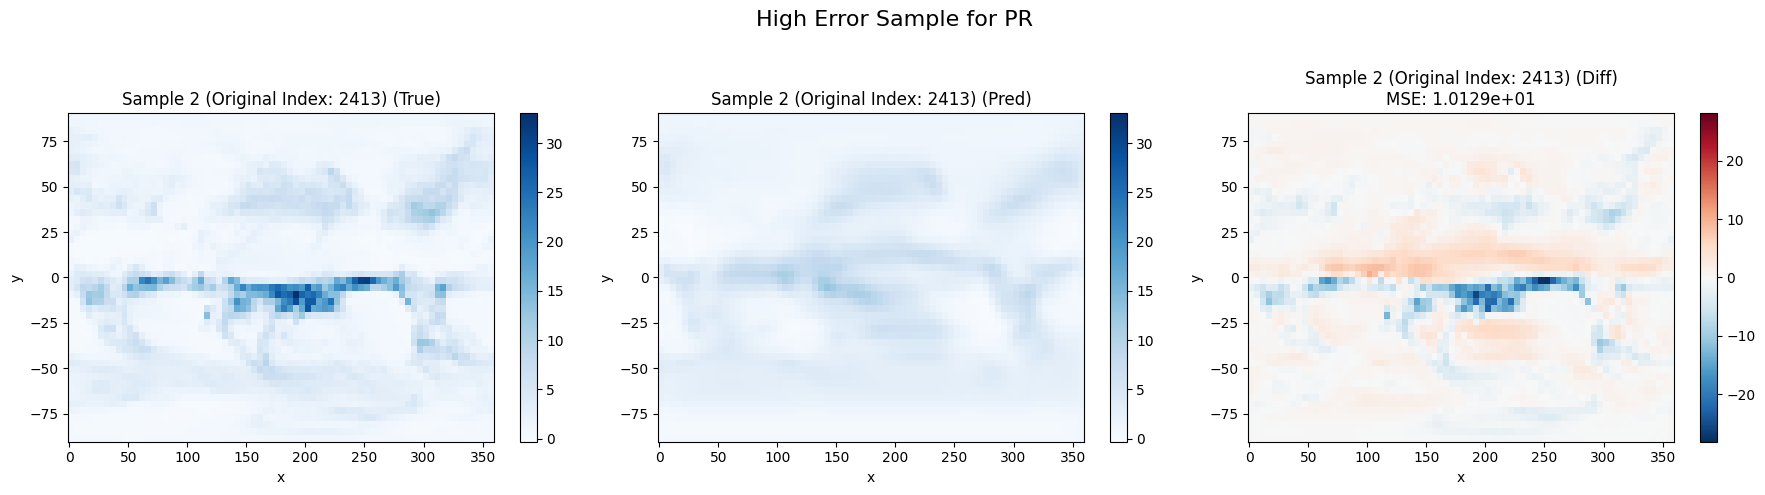

High-error sample plot saved to: high_error_sample_pr_2.png


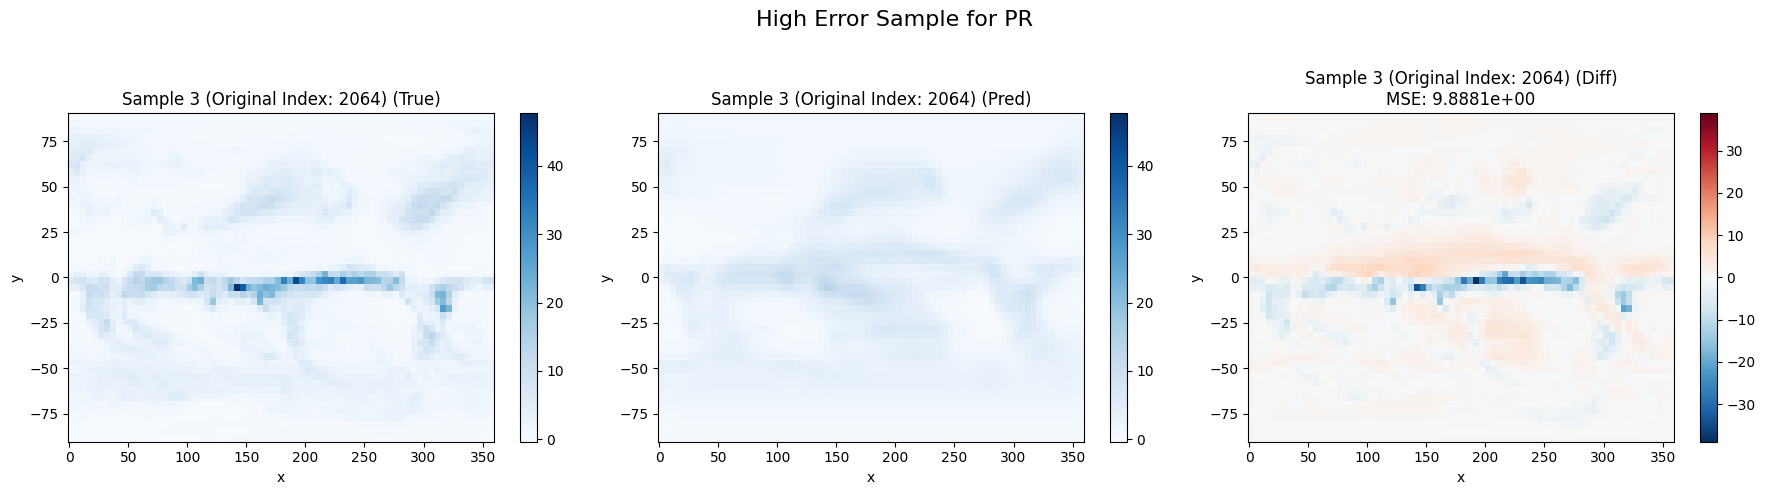

High-error sample plot saved to: high_error_sample_pr_3.png


In [54]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Ensure 'lightning_module' (your trained ClimateEmulationModule instance) is available
# Ensure 'datamodule' (your ClimateDataModule instance, after setup) is available

if 'lightning_module' not in globals() or not hasattr(lightning_module, 'model'):
    print("ERROR: 'lightning_module' with a trained model is not defined. Please ensure it's loaded.")
elif 'datamodule' not in globals() or not hasattr(datamodule, 'train_dataloader'):
    print("ERROR: 'datamodule' is not defined or not set up. Please ensure it's available.")
else:
    model = lightning_module.model
    model.eval() # Ensure model is in evaluation mode
    if torch.cuda.is_available() and next(model.parameters()).is_cuda: # Check if model was on CUDA
        device = torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() and next(model.parameters()).device.type == 'mps':
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
    model.to(device)
    
    normalizer = datamodule.normalizer
    train_loader = datamodule.train_dataloader()
    
    all_errors_per_var = {var_name: [] for var_name in datamodule.output_vars}
    all_true_samples_per_var = {var_name: [] for var_name in datamodule.output_vars}
    all_pred_samples_per_var = {var_name: [] for var_name in datamodule.output_vars}
    
    print("Calculating errors on the training set (this might take a while)...")
    with torch.no_grad():
        for batch_idx, (x_batch, y_batch_norm) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_hat_batch_norm = model(x_batch).cpu() # Predictions (normalized)
            
            # Denormalize for error calculation in physical units (optional, but often more interpretable)
            # Or calculate error on normalized data if preferred: mse_batch = ((y_hat_batch_norm - y_batch_norm)**2)
            
            y_batch_denorm = normalizer.inverse_transform_output(y_batch_norm.numpy())
            y_hat_batch_denorm = normalizer.inverse_transform_output(y_hat_batch_norm.numpy())

            # Calculate MSE per sample, per variable
            # Shape: (batch_size, num_output_vars, H, W)
            error_sq_batch = (y_hat_batch_denorm - y_batch_denorm)**2
            
            for i, var_name in enumerate(datamodule.output_vars):
                # Mean squared error for this variable, for each sample in batch
                mse_per_sample_var = np.mean(error_sq_batch[:, i, :, :], axis=(1, 2))
                all_errors_per_var[var_name].extend(mse_per_sample_var)
                all_true_samples_per_var[var_name].extend(y_batch_denorm[:, i, :, :])
                all_pred_samples_per_var[var_name].extend(y_hat_batch_denorm[:, i, :, :])
            
            if batch_idx % 10 == 0:
                print(f"  Processed batch {batch_idx+1}/{len(train_loader)}")
            # For faster debugging, you can break early:
            # if batch_idx > 20: # Process only a few batches
            #     print("Stopping early for debugging purposes.")
            #     break 

    print("Error calculation finished.")

    # --- Visualization part ---
    lat, lon = datamodule.get_coords() # get lat/lon from datamodule
    
    def plot_comparison_for_problem_a(true_data, pred_data, title_prefix, var_name, error_val):
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        time_placeholder = np.arange(1) # For single sample
        
        true_xr = xr.DataArray(true_data[np.newaxis,...], dims=["time", "y", "x"], coords={"time":time_placeholder, "y": lat, "x": lon}).squeeze()
        pred_xr = xr.DataArray(pred_data[np.newaxis,...], dims=["time", "y", "x"], coords={"time":time_placeholder, "y": lat, "x": lon}).squeeze()

        vmin = min(true_xr.min().item(), pred_xr.min().item())
        vmax = max(true_xr.max().item(), pred_xr.max().item())
        cmap_val = 'viridis' if var_name == 'tas' else 'Blues'

        true_xr.plot(ax=axs[0], cmap=cmap_val, vmin=vmin, vmax=vmax, add_colorbar=True)
        axs[0].set_title(f"{title_prefix} (True)")
        pred_xr.plot(ax=axs[1], cmap=cmap_val, vmin=vmin, vmax=vmax, add_colorbar=True)
        axs[1].set_title(f"{title_prefix} (Pred)")
        diff = pred_xr - true_xr
        abs_max_diff = np.max(np.abs(diff.data))
        diff.plot(ax=axs[2], cmap='RdBu_r', vmin=-abs_max_diff, vmax=abs_max_diff, add_colorbar=True)
        axs[2].set_title(f"{title_prefix} (Diff)\nMSE: {error_val:.4e}")
        fig.suptitle(f"High Error Sample for {var_name.upper()}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        return fig

    num_samples_to_plot = 3
    for var_idx, var_name in enumerate(datamodule.output_vars):
        print(f"\n--- Top {num_samples_to_plot} High-Error Training Samples for Variable: {var_name.upper()} ---")
        if not all_errors_per_var[var_name]:
            print(f"No error data collected for {var_name}.")
            continue

        errors_np = np.array(all_errors_per_var[var_name])
        true_samples_np = np.array(all_true_samples_per_var[var_name])
        pred_samples_np = np.array(all_pred_samples_per_var[var_name])

        # Get indices of top N errors
        top_error_indices = np.argsort(errors_np)[-num_samples_to_plot:][::-1]

        for i, sample_idx in enumerate(top_error_indices):
            true_sample = true_samples_np[sample_idx]
            pred_sample = pred_samples_np[sample_idx]
            error_val = errors_np[sample_idx]
            
            fig = plot_comparison_for_problem_a(true_sample, pred_sample, 
                                                f"Sample {i+1} (Original Index: {sample_idx})", 
                                                var_name, error_val)
            plt.show()
            # Save the figure
            fig_path_high_error = f"high_error_sample_{var_name}_{i+1}.png"
            fig.savefig(fig_path_high_error)
            print(f"High-error sample plot saved to: {fig_path_high_error}")